In [14]:
import netCDF4 as nc4
import numpy as np
from matplotlib import pyplot as plt
import copy
import pandas as pd
import time
# import xarray as xr

In [2]:
# Parameters for calculating vapor pressure
a1=6.107799961
a2=4.436518521e-1
a3=1.428945805e-2
a4=2.650648471e-4
a5=3.031240396e-6
a6=2.034080948e-8
a7=6.136820929e-11


### Read in climate and extract the corresponding time series

In [3]:
# Data path
# GSWP3
f_sanrafael = '/pscratch/sd/s/sshu3/e3sm_scratch/pm-cpu/sanrafael.pm-cpu.Ea00a6ed2f-F23ee93f0.2023-10-21/run/hist/sanrafael.test.1958_2013.nc'
f_villamadero = '/pscratch/sd/s/sshu3/e3sm_scratch/pm-cpu/villamadero.pm-cpu.Ea00a6ed2f-F23ee93f0.2023-10-21/run/hist/villamadero.test.1958_2013.nc'
# TerraClimate
# Wind speed is at 10m.
f_terra_tmax_pre = '/pscratch/sd/s/sshu3/Terraclimate/TerraClimate_tmax_'
f_terra_tmin_pre = '/pscratch/sd/s/sshu3/Terraclimate/TerraClimate_tmin_'
f_terra_prec_pre = '/pscratch/sd/s/sshu3/Terraclimate/TerraClimate_ppt_'
f_terra_wind_pre = '/pscratch/sd/s/sshu3/Terraclimate/TerraClimate_ws_'
f_terra_rad_pre = '/pscratch/sd/s/sshu3/Terraclimate/TerraClimate_srad_'
suf = '.nc'

# ERA (1979 - 2022)
f_era_tbot_pre = '/global/cfs/cdirs/e3sm/inputdata/atm/datm7/atm_forcing.datm7.ERA.0.25d.v5.c180614/tbot/elmforc.ERA5.c2018.0.25d.t2m.'
f_era_prec_pre = '/global/cfs/cdirs/e3sm/inputdata/atm/datm7/atm_forcing.datm7.ERA.0.25d.v5.c180614/prec/elmforc.ERA5.c2018.0.25d.mcpr.'
f_era_prel_pre = '/global/cfs/cdirs/e3sm/inputdata/atm/datm7/atm_forcing.datm7.ERA.0.25d.v5.c180614/prec/elmforc.ERA5.c2018.0.25d.mlspr.'
f_era_wind_pre = '/global/cfs/cdirs/e3sm/inputdata/atm/datm7/atm_forcing.datm7.ERA.0.25d.v5.c180614/wind/elmforc.ERA5.c2018.0.25d.v10.'
f_era_rad_pre = '/global/cfs/cdirs/e3sm/inputdata/atm/datm7/atm_forcing.datm7.ERA.0.25d.v5.c180614/swdn/elmforc.ERA5.c2018.0.25d.msdwswrf.'
f_era_pbot_pre = '/global/cfs/cdirs/e3sm/inputdata/atm/datm7/atm_forcing.datm7.ERA.0.25d.v5.c180614/pbot/elmforc.ERA5.c2018.0.25d.sp.'
f_era_lwdn_pre = '/global/cfs/cdirs/e3sm/inputdata/atm/datm7/atm_forcing.datm7.ERA.0.25d.v5.c180614/lwdn/elmforc.ERA5.c2018.0.25d.msdwlwrf.'
f_era_dewt_pre = '/global/cfs/cdirs/e3sm/inputdata/atm/datm7/atm_forcing.datm7.ERA.0.25d.v5.c180614/tdew/elmforc.ERA5.c2018.0.25d.d2m.'

# Sr - 19.26932, -98.61660 
# Vm - 19.35500, -101.27070
# Rio Frio - 19.34, -98.66
latid_sr = int((90.0-19.0)*24.0) - round(0.26932/(1.0/24.0))
lonid_sr = int((180.0-98.0)*24.0) - round(0.6166/(1.0/24.0))
latid_vm = int((90.0-19.0)*24.0) - round(0.355/(1.0/24.0))
lonid_vm = int((180.0-101.0)*24.0) - round(0.2707/(1.0/24.0))

# For ERA
latid_sr_era = int((90.0+19.0)*4.0) + round(0.26932/(1.0/4.0))
lonid_sr_era = int((360.0-98.0)*4.0) - round(0.6166/(1.0/4.0))
latid_vm_era = int((90.0+19.0)*4.0) + round(0.355/(1.0/4.0))
lonid_vm_era = int((360.0-101.0)*4.0) - round(0.2707/(1.0/4.0))

# For GPCC-2020
latid_sr_gpcc = int((90.0-19.0)*4.0) - round(0.34/(1.0/4.0))
lonid_sr_gpcc = int((360.0-98.0)*4.0) - round(0.66/(1.0/4.0))
latid_vm_gpcc = int((90.0-19.0)*4.0) - round(0.355/(1.0/4.0))
lonid_vm_gpcc = int((360.0-101.0)*4.0) - round(0.2707/(1.0/4.0))

# For Chirps-v2
latid_sr_chirps = int((50.0+19.0)*20.0) + round(0.26932/(1.0/20.0))
lonid_sr_chirps = int((180.0-98.0)*20.0) - round(0.6166/(1.0/20.0))
latid_vm_chirps = int((50.0+19.0)*20.0) + round(0.355/(1.0/20.0))
lonid_vm_chirps = int((180.0-101.0)*20.0) - round(0.2707/(1.0/20.0))

In [4]:
# Extract site-level ERA data
# This step will take much longer than expected. Usually 1 hour every 10 years
start = time.time()

fout_pre = '/pscratch/sd/s/sshu3/site_met/sanrafael_era5/'
fout_suf = '.nc'

yrbeg = 1979
yrend = 2023

for i in np.arange(yrbeg,yrend):
    for j in np.arange(1,13):
        dom = np.array((31, 28, 31, 30, 31, 30, 31, 31, 30, 31, 30, 31))
        nlen = 24 * dom[j-1]
        
        sr_tbot_era = np.zeros((nlen))
        sr_prec_era = np.zeros((nlen))
        sr_wind_era = np.zeros((nlen))
        sr_rad_era = np.zeros((nlen))
        sr_tdew_era = np.zeros((nlen))
        sr_pbot_era = np.zeros((nlen))
        sr_qa_era = np.zeros((nlen))
        sr_rh_era = np.zeros((nlen))
        sr_lrad_era = np.zeros((nlen))
        
        # TBOT
        if(j < 10):
            fp = f_era_tbot_pre+str(i)+'-0'+str(j)+suf
        else:
            fp = f_era_tbot_pre+str(i)+'-'+str(j)+suf
        dtc = nc4.Dataset(fp)
        dtbot = dtc['t2m']
        temp_array_1 = dtbot[:,latid_sr_era,lonid_sr_era]
        dtc.close()       
        sr_tbot_era = copy.deepcopy(temp_array_1)

        # Monthly Precipitation mm/s
        if(j < 10):
            fp = f_era_prec_pre+str(i)+'-0'+str(j)+suf
        else:
            fp = f_era_prec_pre+str(i)+'-'+str(j)+suf    
        dtc = nc4.Dataset(fp)
        dprec = dtc['mcpr']
        temp_array_1 = dprec[:,latid_sr_era,lonid_sr_era]
        dtc.close()
        if(j < 10):
            fp = f_era_prel_pre+str(i)+'-0'+str(j)+suf
        else:
            fp = f_era_prel_pre+str(i)+'-'+str(j)+suf    
        dtc = nc4.Dataset(fp)
        dprel = dtc['mlspr']
        temp_array_2 = dprel[:,latid_sr_era,lonid_sr_era]
        dtc.close()               
        sr_prec_era = copy.deepcopy(temp_array_1+temp_array_2)
        
        # Wind, 10 m wind speed, m s-1
        if(j < 10):
            fp = f_era_wind_pre+str(i)+'-0'+str(j)+suf
        else:
            fp = f_era_wind_pre+str(i)+'-'+str(j)+suf    
        dtc = nc4.Dataset(fp)
        dwind_u = dtc['u10']
        dwind_v = dtc['v10']
        temp_array_1u = dwind_u[:,latid_sr_era,lonid_sr_era]
        temp_array_1v = dwind_v[:,latid_sr_era,lonid_sr_era]
        dtc.close()
        sr_wind_era = copy.deepcopy(np.sqrt(temp_array_1u*temp_array_1u+temp_array_1v*temp_array_1v))
        
        # Radiation, W m-2
        if(j < 10):
            fp = f_era_rad_pre+str(i)+'-0'+str(j)+suf
        else:
            fp = f_era_rad_pre+str(i)+'-'+str(j)+suf    
        dtc = nc4.Dataset(fp)
        drad = dtc['msdwswrf']
        temp_array_1 = drad[:,latid_sr_era,lonid_sr_era]
        dtc.close()
        sr_rad_era = copy.deepcopy(temp_array_1)
        
        # Longwave radiation, W m-2
        if(j < 10):
            fp = f_era_lwdn_pre+str(i)+'-0'+str(j)+suf
        else:
            fp = f_era_lwdn_pre+str(i)+'-'+str(j)+suf    
        dtc = nc4.Dataset(fp)
        drad = dtc['msdwlwrf']
        temp_array_1 = drad[:,latid_sr_era,lonid_sr_era]
        dtc.close()
        sr_lrad_era = copy.deepcopy(temp_array_1)
        
        # Dew point T, K
        if(j < 10):
            fp = f_era_dewt_pre+str(i)+'-0'+str(j)+suf
        else:
            fp = f_era_dewt_pre+str(i)+'-'+str(j)+suf    
        dtc = nc4.Dataset(fp)
        d2m = dtc['d2m']
        temp_array_1 = d2m[:,latid_sr_era,lonid_sr_era]
        dtc.close()
        sr_tdew_era = copy.deepcopy(temp_array_1)
        
        # Surface pressure, Pa
        if(j < 10):
            fp = f_era_pbot_pre+str(i)+'-0'+str(j)+suf
        else:
            fp = f_era_pbot_pre+str(i)+'-'+str(j)+suf    
        dtc = nc4.Dataset(fp)
        dsp = dtc['sp']
        temp_array_1 = dsp[:,latid_sr_era,lonid_sr_era]
        dtc.close()
        sr_pbot_era = copy.deepcopy(temp_array_1)
        
        # # Transfer dew point temperature to specific humidity
        # dew = sr_tdew_era - 273.16
        # ea = a1 +dew*(a2+dew*(a3+dew*(a4+dew*(a5+dew*(a6+dew*a7)))))
        # ea = ea * 100.0 # Conversion millibar --> Pascal
        # # 0.62198 - humidity ratio
        # sr_qa_era = 0.62198*ea/(sr_pbot_era - 0.377*ea)
        
        # Transfer dew point temperature to relative humidity
        dew = sr_tdew_era - 273.16
        tair = sr_tbot_era - 273.16
        ea = a1 +dew*(a2+dew*(a3+dew*(a4+dew*(a5+dew*(a6+dew*a7)))))
        es = a1 +tair*(a2+tair*(a3+tair*(a4+tair*(a5+tair*(a6+tair*a7)))))
        sr_rh_era = ea/(es+1e-10)
      
        # Write into corresponding file
        if(j < 10):
            fp = fout_pre+str(i)+'-0'+str(j)+fout_suf
        else:
            fp = fout_pre+str(i)+'-'+str(j)+fout_suf
        dtc = nc4.Dataset(fp, 'r+')
        dtc['TBOT'][:] = sr_tbot_era
        dtc['PSRF'][:] = sr_pbot_era
        dtc['PRECTmms'][:] = sr_prec_era
        dtc['WIND'][:] = sr_wind_era
        dtc['FSDS'][:] = sr_rad_era
        dtc['FLDS'][:] = sr_lrad_era
        dtc['RH'][:] = sr_rh_era
        dtc.close()

end = time.time()
print('Time elapsed: ', end - start)
        

Time elapsed:  20209.82732772827


### Bias correction for site level atmospheric forcing

In [15]:
# Obtain TerraClimate data for site level
yrbeg = 1979
yrend = 2023
nlen = 12 * (yrend - yrbeg + 1)
sr_tmax_terra = np.zeros((nlen))
sr_tmin_terra = np.zeros((nlen))
sr_prec_terra = np.zeros((nlen))
sr_wind_terra = np.zeros((nlen))
sr_rad_terra = np.zeros((nlen))
vm_tmax_terra = np.zeros((nlen))
vm_tmin_terra = np.zeros((nlen))
vm_prec_terra = np.zeros((nlen))
vm_wind_terra = np.zeros((nlen))
vm_rad_terra = np.zeros((nlen))

for i in np.arange(yrbeg,yrend):
    pbeg = (i-yrbeg)*12
    pend = (i-yrbeg+1)*12
    # Tmax
    fp = f_terra_tmax_pre+str(i)+suf
    dtc = nc4.Dataset(fp)
    dtmax = dtc['tmax']
    sr_tmax_terra[pbeg:pend] = dtmax[:,latid_sr,lonid_sr]
    dtc.close()
    # Tmin
    fp = f_terra_tmin_pre+str(i)+suf
    dtc = nc4.Dataset(fp)
    dtmin = dtc['tmin']
    sr_tmin_terra[pbeg:pend] = dtmin[:,latid_sr,lonid_sr]
    dtc.close()
    # Wind, 10 m wind speed, m s-1
    fp = f_terra_wind_pre+str(i)+suf
    dtc = nc4.Dataset(fp)
    dwind = dtc['ws']
    sr_wind_terra[pbeg:pend] = dwind[:,latid_sr,lonid_sr]
    dtc.close()


In [33]:
# Get Daymet vapor pressure data for site level
# Daymet starts from 1980, so we don;t perform any adjustment for year 1979.
# We only use the actual vapor pressure
# Then this daily timeseries will be user to correct relative humidity of San Rafael site through linear scale
fp = '/pscratch/sd/s/sshu3/site_met/daymet/Sanrafael_daymet.csv'
df_daymet = pd.read_csv(fp, header=0)
yrbeg = 1980
yrend = 2022
nlen = 365 * (yrend - yrbeg + 1)
sr_ea_daymet = df_daymet.vp.to_numpy()[(yrbeg-1980)*365:(yrend - yrbeg +1)*365]



In [10]:
# reopen the climate data if needed
yrbeg = 1979
yrend = 2023
fout_pre = '/pscratch/sd/s/sshu3/site_met/sanrafael_era5_bias_corrected/'
fout_suf = '.nc'

jday_beg = [0, 31, 59, 90, 120, 151, 181, 212, 243, 273, 304, 334]
jday_end = [31, 59, 90, 120, 151, 181, 212, 243, 273, 304, 334, 365]
jday_cnt = [31, 28, 31, 30, 31, 30, 31, 31, 30, 31, 30, 31]

for i in np.arange(yrbeg,yrend):
    for j in np.arange(1,13):
        if(j < 10):
            fp = fout_pre+str(i)+'-0'+str(j)+fout_suf
        else:
            fp = fout_pre+str(i)+'-'+str(j)+fout_suf
        dtc = nc4.Dataset(fp, 'r+')
        sr_tbot_era = dtc['TBOT'][:]
        sr_wind_era = dtc['WIND'][:]
        sr_rh_era = dtc['QBOT'][:]
        # sr_pbot_era = dtc['PSRF'][:]

        # For each month we get the maximum and minimum temperature and calculate the mean of that month.
        # Use the difference between TerraClimate and ERA5 to correct the temperature
        # Same method is applied to correct wind speed.
        # Before correcting temperature bias, dew point temperature must be transferred into either specific or relative humidity.
        # Currently we just use linear scaling (Chen et al., 2022)
        sr_tmax_era = np.nanmean(np.nanmax(sr_tbot_era.reshape(-1, 24), axis=1))
        sr_tmin_era = np.nanmean(np.nanmin(sr_tbot_era.reshape(-1, 24), axis=1))
        sr_wmean_era = np.nanmean(sr_wind_era)
        idx = (i-yrbeg)*12+j-1
        corr_tbot = (sr_tmax_terra[idx]+273.16 - sr_tmax_era + sr_tmin_terra[idx]+273.16 - sr_tmin_era) / 2.0
        sr_tbot_era[:] = sr_tbot_era[:] + corr_tbot
        corr_wind =  sr_wind_terra[idx] - sr_wmean_era
        sr_wind_era[:] = sr_wind_era[:] + corr_wind
        
        # Use daymet actual vapor pressure to adjust RH
        nlen = 24 * jday_cnt[j-1]       
        ea_copy = np.zeros((nlen))
        
        tair = sr_tbot_era - 273.16
        es = a1 +tair*(a2+tair*(a3+tair*(a4+tair*(a5+tair*(a6+tair*a7)))))
        ea = es * sr_rh_era
        ea_daily = np.nanmean(ea.reshape(-1, 24), axis=1)
        if(i>=1980):
            jday_beg_pt = 365*(i-1980)+jday_beg[j-1]
            jday_end_pt = 365*(i-1980)+jday_end[j-1]
            corr_ea = sr_ea_daymet[jday_beg_pt:jday_end_pt]*0.01 - ea_daily
            for p in np.arange(0, jday_cnt[j-1]):
                ea[24*p:24*(p+1),0,0] = ea[24*p:24*(p+1),0,0] + corr_ea[p]
                sr_rh_era[24*p:24*(p+1),0,0] = ea[24*p:24*(p+1),0,0]/es[24*p:24*(p+1),0,0]

        # Sanity check for RH
        sr_rh_era[sr_rh_era>1.0] = 1.0
        sr_rh_era[sr_rh_era<0.1] = 0.1
        # # Transfer RH to Q
        # ea = sr_rh_era*es    # Update ea
        # ea = ea * 100.0 # Conversion millibar --> Pascal
        # # # 0.62198 - humidity ratio
        # sr_qa_era = 0.62198*ea/(sr_pbot_era - 0.377*ea)       
        
        dtc['TBOT'][:] = sr_tbot_era
        dtc['WIND'][:] = sr_wind_era
        dtc['QBOT'][:] = sr_rh_era * 100
        dtc.close()



IndexError: QBOT not found in /

In [11]:
fp

'/pscratch/sd/s/sshu3/FATES_MRV/sanrafael/CLM1PT_data/1979-01.nc'

In [13]:
# Read in data and make plot to validate
# Obtain TerraClimate data
yrbeg = 1979
yrend = 2023
nlen = 12 * (yrend - yrbeg)
sr_tmax_era = np.zeros((nlen))
sr_tmin_era = np.zeros((nlen))
sr_wmean_era = np.zeros((nlen))
sr_ea_era = np.zeros((nlen))

for i in np.arange(yrbeg,yrend):
    for j in np.arange(1,13):
        if(j < 10):
            fp = fout_pre+str(i)+'-0'+str(j)+fout_suf
        else:
            fp = fout_pre+str(i)+'-'+str(j)+fout_suf
        dtc = nc4.Dataset(fp, 'r+')
        sr_tbot_era = dtc['TBOT'][:]
        sr_wind_era = dtc['WIND'][:]
        sr_rh_era = dtc['RH'][:]
        dtc.close()
        
        pbeg = (i-yrbeg)*12+j-1
        sr_tmax_era[pbeg] = np.nanmean(np.nanmax(sr_tbot_era.reshape(-1, 24), axis=1))
        sr_tmin_era[pbeg] = np.nanmean(np.nanmin(sr_tbot_era.reshape(-1, 24), axis=1))
        sr_wmean_era[pbeg] = np.nanmean(sr_wind_era)
        tair = sr_tbot_era - 273.16
        sr_es_era = a1 +tair*(a2+tair*(a3+tair*(a4+tair*(a5+tair*(a6+tair*a7)))))
        sr_ea_era[pbeg] = np.nanmean(sr_rh_era*sr_es_era)




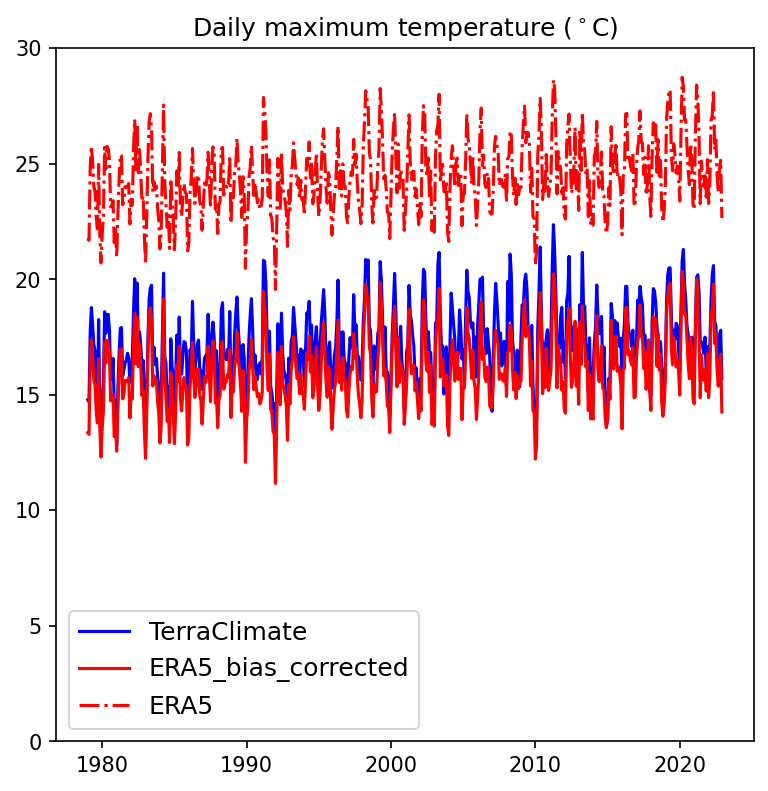

In [24]:
# Comparison Tmax 
yr_axis = np.arange(1979, 2023, 1.0/12.0)
plot_len = len(yr_axis)
# Tmax, not sure how terra climate calculate Tmax and Tmin, 
# but it shall be monthly mean of daily Tmax and Tmin
fig = plt.figure(figsize=(6,6), dpi=150)
plt.plot(yr_axis, sr_tmax_terra[0:plot_len], 'b-')
plt.plot(yr_axis, sr_tmax_era[0:plot_len]-273.16, 'r-')
plt.plot(yr_axis, sr_tmax_era[0:plot_len]-273.16+8.4, 'r-.')
plt.title('Daily maximum temperature ($^\circ$C)')
plt.legend(['TerraClimate', 'ERA5_bias_corrected', 'ERA5'], fontsize = 12)
plt.ylim([0, 30])
plt.savefig('Hist_max_T.png')

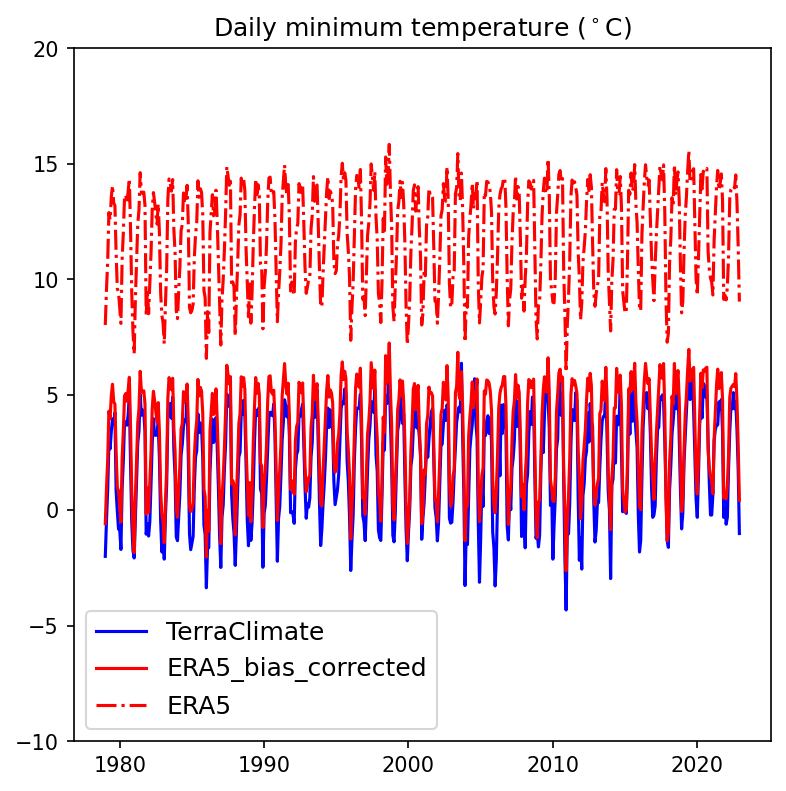

In [29]:
# Comparison Tmin 
yr_axis = np.arange(1979, 2023, 1.0/12.0)
plot_len = len(yr_axis)
# Tmax, not sure how terra climate calculate Tmax and Tmin, 
# but it shall be monthly mean of daily Tmax and Tmin
fig = plt.figure(figsize=(6,6), dpi=150)
plt.plot(yr_axis, sr_tmin_terra[0:plot_len], 'b-')
plt.plot(yr_axis, sr_tmin_era[0:plot_len]-273.16, 'r-')
plt.plot(yr_axis, sr_tmin_era[0:plot_len]-273.16+8.6, 'r-.')
plt.title('Daily minimum temperature ($^\circ$C)')
plt.legend(['TerraClimate', 'ERA5_bias_corrected', 'ERA5'], fontsize = 12)
plt.ylim([-10, 20])
plt.savefig('Hist_min_T.png')

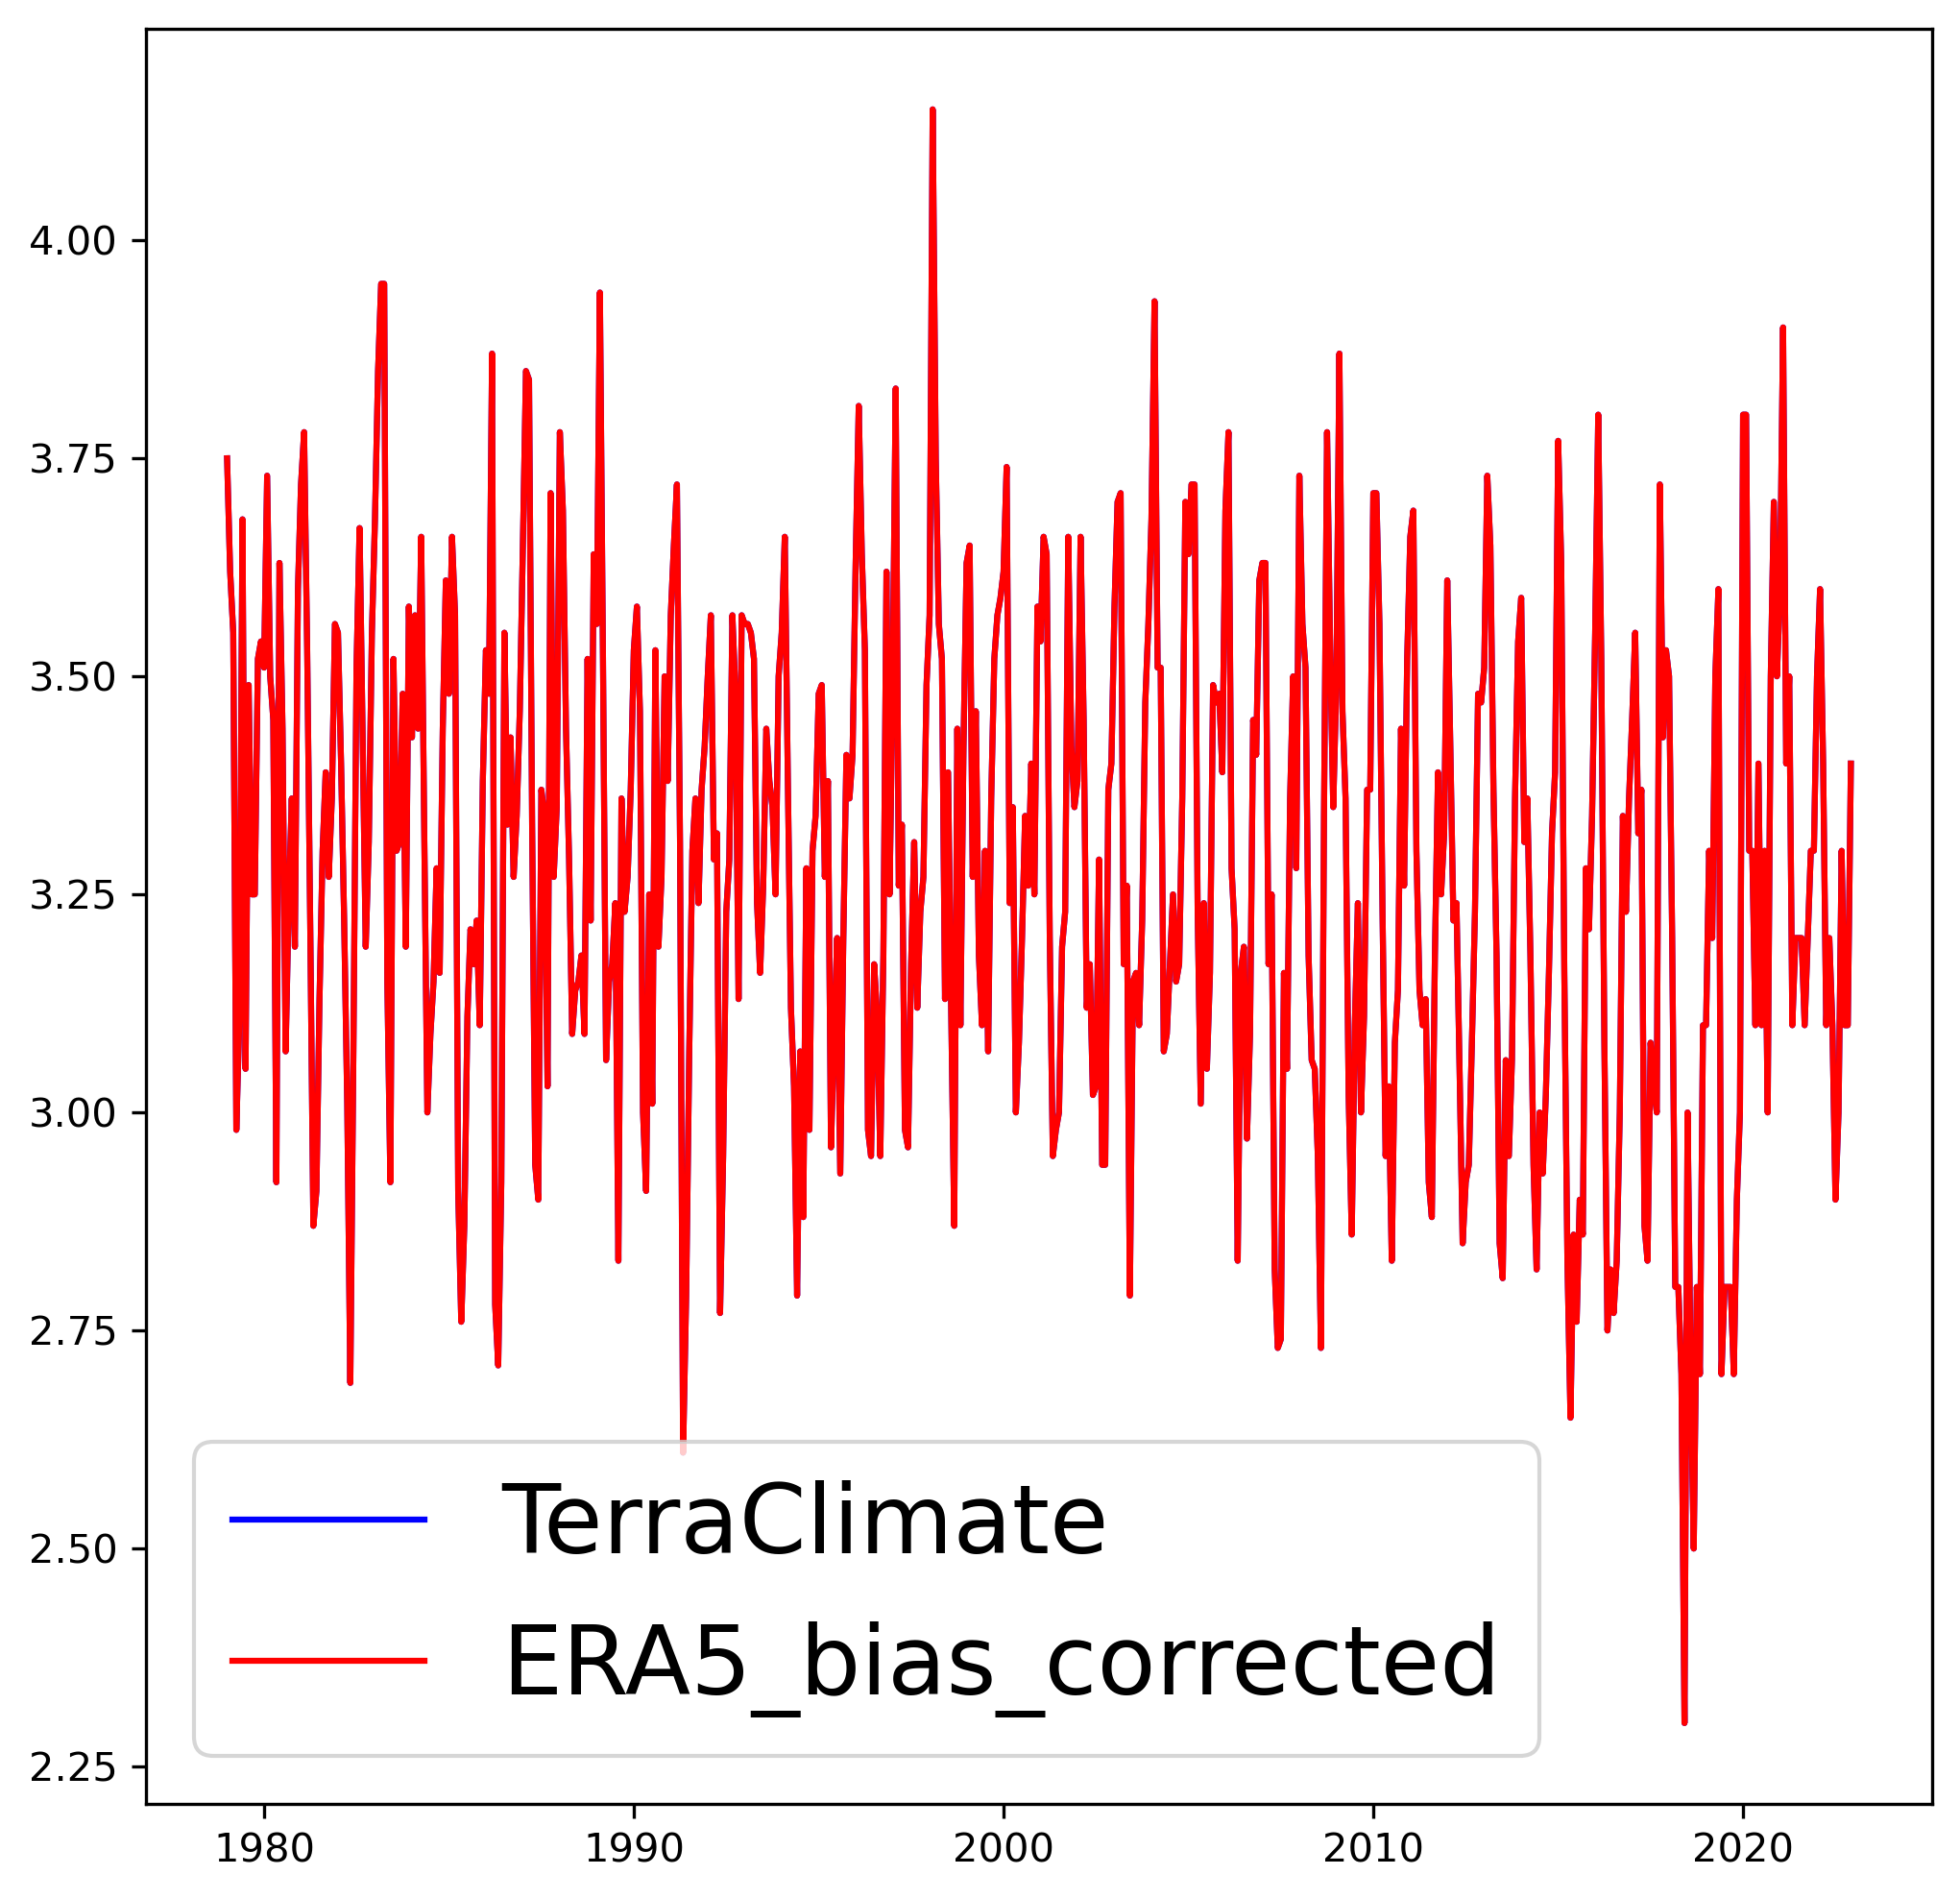

In [20]:
# Comparison Wind
yr_axis = np.arange(1979, 2023, 1.0/12.0)
plot_len = len(yr_axis)
# Tmax, not sure how terra climate calculate Tmax and Tmin, 
# but it shall be monthly mean of daily Tmax and Tmin
fig = plt.figure(figsize=(8,8), dpi=300)
plt.plot(yr_axis, sr_wind_terra[0:plot_len], 'b-')
plt.plot(yr_axis, sr_wmean_era[0:plot_len], 'r-')
plt.legend(['TerraClimate', 'ERA5_bias_corrected'], fontsize = 24)
# plt.ylim([2, 5])

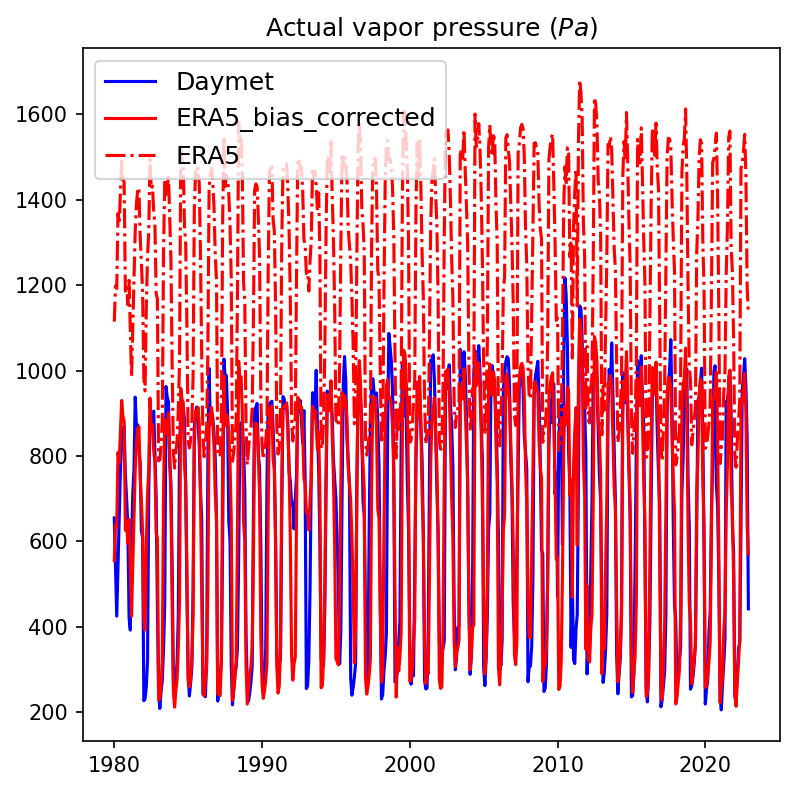

In [37]:
# Comparison EA (Actual vapor pressure, Pa)
yr_axis = np.arange(1980, 2023, 1.0/12.0)
plot_len = len(yr_axis)
sr_ea_daymet_mo = np.zeros((len(yr_axis)))
for i in np.arange(1980,2023):
    for j in np.arange(1,13):
        jday_beg_pt = 365*(i-1980)+jday_beg[j-1]
        jday_end_pt = 365*(i-1980)+jday_end[j-1]
        sr_ea_daymet_mo[(i-1980)*12+j-1] = np.nanmean(sr_ea_daymet[jday_beg_pt:jday_end_pt])
# Tmax, not sure how terra climate calculate Tmax and Tmin, 
# but it shall be monthly mean of daily Tmax and Tmin
fig = plt.figure(figsize=(6,6), dpi=150)
plt.title('Actual vapor pressure ($Pa$)')
plt.plot(yr_axis, sr_ea_daymet_mo[0:plot_len], 'b-')
plt.plot(yr_axis, sr_ea_era[0:plot_len], 'r-')
plt.plot(yr_axis, sr_ea_era[0:plot_len]+560, 'r-.')
plt.legend(['Daymet', 'ERA5_bias_corrected', 'ERA5'], fontsize = 12)
plt.savefig('Hist_vapor_pressure.png')

### Extract and bias correct SSP1 and SSP5 climate data for sites

In [114]:
# Extract site data from global SSP1/SSP5 outputs

ssp1_pre = '/global/cfs/projectdirs/m3520/share/cesm_inputdata/ssp1/monthly_data/b.e21.BSSP126cmip6.f09_g17.CMIP6-SSP1-2.6.102.cpl.ha2x3h.'
ssp1_suf = '.nc'

ssp5_pre = '/global/cfs/projectdirs/m3520/share/cesm_inputdata/ssp5/monthly_data/b.e21.BSSP585cmip6.f09_g17.CMIP6-SSP5-8.5.102.cpl.ha2x3h.'
ssp5_suf = '.nc'

ssp1_pre_out = '/pscratch/sd/s/sshu3/cesm_input_datasets/atm/datm7/sanrafael_e3sm_ssp126/'
ssp1_suf_out = '.nc'

ssp5_pre_out = '/pscratch/sd/s/sshu3/cesm_input_datasets/atm/datm7/sanrafael_e3sm_ssp585/'
ssp5_suf_out = '.nc'

yrbeg = 2015
yrend = 2101

# Sr - 19.26932, -98.61660 
# Vm - 19.35500, -101.27070
# Rio Frio - 19.34, -98.66
latid_sr_09x125 = int((19.0-(-90.0))/0.9) + round(0.26932/0.9)
lonid_sr_09x125 = int((360.0-98.0)/1.25) - round(0.6166/1.25)

rain_in = ['a2x3h_Faxa_rainc', 'a2x3h_Faxa_rainl', 'a2x3h_Faxa_snowc', 'a2x3h_Faxa_snowl']
rain_out = 'PRECTmms'
sw_in = ['a2x3h_Faxa_swndr', 'a2x3h_Faxa_swvdr', 'a2x3h_Faxa_swndf', 'a2x3h_Faxa_swvdf']
sw_out = 'FSDS'
lw_in = ['a2x3h_Faxa_lwdn']
lw_out = 'FLDS'
temp_in = ['a2x3h_Sa_tbot']
temp_out = 'TBOT'
wind_in = ['a2x3h_Sa_u', 'a2x3h_Sa_v']
wind_out = 'WIND'
pres_in = ['a2x3h_Sa_pbot']
pres_out = 'PSRF'
# Calculate q first then transfer to RH, which will be used in bias correction 
q_in = ['a2x3h_Sa_shum']
q_out = 'RH'

# Extract the site point from global output first
for iyr in np.arange(yrbeg, yrend):
    for imo in np.arange(1, 13):
#         cur_f = ssp1_pre+str(iyr).zfill(4)+'-'+str(imo).zfill(2)+ssp1_suf
#         dtc = nc4.Dataset(cur_f, 'r')
#         timelen = len(dtc['time'][:])
#         # Rain
#         rain = np.zeros((timelen))
#         for ivar in rain_in:
#             dvar = dtc[ivar]
#             rain = rain + dvar[:,latid_sr_09x125,lonid_sr_09x125]
#         # SW
#         sw = np.zeros((timelen))
#         for ivar in sw_in:
#             dvar = dtc[ivar]
#             sw = sw + dvar[:,latid_sr_09x125,lonid_sr_09x125]
#         # LW
#         lw = np.zeros((timelen))
#         for ivar in lw_in:
#             dvar = dtc[ivar]
#             lw = lw + dvar[:,latid_sr_09x125,lonid_sr_09x125]
#         # Tbot
#         tbot = np.zeros((timelen))
#         for ivar in temp_in:
#             dvar = dtc[ivar]
#             tbot = tbot + dvar[:,latid_sr_09x125,lonid_sr_09x125]        
#         # Pressure
#         pres = np.zeros((timelen))
#         for ivar in pres_in:
#             dvar = dtc[ivar]
#             pres = pres + dvar[:,latid_sr_09x125,lonid_sr_09x125]      
#         # Humiduty, need to transfer from specific to relative
#         q = np.zeros((timelen))
#         for ivar in q_in:
#             dvar = dtc[ivar]
#             q = q + dvar[:,latid_sr_09x125,lonid_sr_09x125] 
#         # Wind
#         wind = np.zeros((timelen))
#         dvar1 = dtc[wind_in[0]]
#         dvar2 = dtc[wind_in[1]]
#         wind = np.sqrt(dvar1[:,latid_sr_09x125,lonid_sr_09x125]*dvar1[:,latid_sr_09x125,lonid_sr_09x125]+
#                       dvar2[:,latid_sr_09x125,lonid_sr_09x125]*dvar2[:,latid_sr_09x125,lonid_sr_09x125])
#         dtc.close()
        
#         # Write to new files
#         cur_f = ssp1_pre_out+str(iyr).zfill(4)+'-'+str(imo).zfill(2)+ssp1_suf_out
#         dtc = nc4.Dataset(cur_f, 'r+')
#         dtc['TBOT'][:] = tbot
#         dtc['PSRF'][:] = pres
#         dtc['PRECTmms'][:] = rain
#         dtc['WIND'][:] = wind
#         dtc['FSDS'][:] = sw
#         dtc['FLDS'][:] = lw
#         # Here RH actually recorded speciufic humidity, will be revised during bias correction
#         dtc['RH'][:] = q
#         dtc.close()

        cur_f = ssp5_pre+str(iyr).zfill(4)+'-'+str(imo).zfill(2)+ssp5_suf
        dtc = nc4.Dataset(cur_f, 'r')
        timelen = len(dtc['time'][:])
        # Rain
        rain = np.zeros((timelen))
        for ivar in rain_in:
            dvar = dtc[ivar]
            rain = rain + dvar[:,latid_sr_09x125,lonid_sr_09x125]
        # SW
        sw = np.zeros((timelen))
        for ivar in sw_in:
            dvar = dtc[ivar]
            sw = sw + dvar[:,latid_sr_09x125,lonid_sr_09x125]
        # LW
        lw = np.zeros((timelen))
        for ivar in lw_in:
            dvar = dtc[ivar]
            lw = lw + dvar[:,latid_sr_09x125,lonid_sr_09x125]
        # Tbot
        tbot = np.zeros((timelen))
        for ivar in temp_in:
            dvar = dtc[ivar]
            tbot = tbot + dvar[:,latid_sr_09x125,lonid_sr_09x125]        
        # Pressure
        pres = np.zeros((timelen))
        for ivar in pres_in:
            dvar = dtc[ivar]
            pres = pres + dvar[:,latid_sr_09x125,lonid_sr_09x125]      
        # Humiduty, need to transfer from specific to relative
        q = np.zeros((timelen))
        for ivar in q_in:
            dvar = dtc[ivar]
            q = q + dvar[:,latid_sr_09x125,lonid_sr_09x125] 
        # Wind
        wind = np.zeros((timelen))
        dvar1 = dtc[wind_in[0]]
        dvar2 = dtc[wind_in[1]]
        wind = np.sqrt(dvar1[:,latid_sr_09x125,lonid_sr_09x125]*dvar1[:,latid_sr_09x125,lonid_sr_09x125]+
                      dvar2[:,latid_sr_09x125,lonid_sr_09x125]*dvar2[:,latid_sr_09x125,lonid_sr_09x125])
        dtc.close()
        
        # Write to new files
        cur_f = ssp5_pre_out+str(iyr).zfill(4)+'-'+str(imo).zfill(2)+ssp5_suf_out
        dtc = nc4.Dataset(cur_f, 'r+')
        dtc['TBOT'][:] = tbot
        dtc['PSRF'][:] = pres
        dtc['PRECTmms'][:] = rain
        dtc['WIND'][:] = wind
        dtc['FSDS'][:] = sw
        dtc['FLDS'][:] = lw
        # Here RH actually recorded speciufic humidity, will be revised during bias correction
        dtc['RH'][:] = q
        dtc.close()

In [153]:
# Bias correction of future projection with historical time series.

# reopen the climate data if needed
yrbeg = 2015
yrend = 2023
fera_pre = '/pscratch/sd/s/sshu3/cesm_input_datasets/atm/datm7/sanrafael_era5_bias_corrected/'
fera_suf = '.nc'
ssp1_pre = '/pscratch/sd/s/sshu3/cesm_input_datasets/atm/datm7/sanrafael_e3sm_ssp126/'
ssp1_suf = '.nc'
ssp5_pre = '/pscratch/sd/s/sshu3/cesm_input_datasets/atm/datm7/sanrafael_e3sm_ssp585/'
ssp5_suf = '.nc'

jday_beg = [0, 31, 59, 90, 120, 151, 181, 212, 243, 273, 304, 334]
jday_end = [31, 59, 90, 120, 151, 181, 212, 243, 273, 304, 334, 365]
jday_cnt = [31, 28, 31, 30, 31, 30, 31, 31, 30, 31, 30, 31]

sr_tbot_era = []
sr_wind_era = []
sr_rh_era = []
sr_pbot_era = []
sr_rain_era = []
sr_sw_era = []
sr_lw_era = []
sr_tbot_ssp1 = []
sr_wind_ssp1 = []
sr_rh_ssp1 = []
sr_pbot_ssp1 = []
sr_rain_ssp1 = []
sr_sw_ssp1 = []
sr_lw_ssp1 = []
sr_tbot_ssp5 = []
sr_wind_ssp5 = []
sr_rh_ssp5 = []
sr_pbot_ssp5 = []
sr_rain_ssp5 = []
sr_sw_ssp5 = []
sr_lw_ssp5 = []

# Get the whole time series
# ERA - hourly
for i in np.arange(yrbeg,yrend):
    for j in np.arange(1,13):
        if(j < 10):
            fp = fera_pre+str(i)+'-0'+str(j)+fera_suf
        else:
            fp = fera_pre+str(i)+'-'+str(j)+fera_suf
        dtc = nc4.Dataset(fp)
        if(i == yrbeg and j == 1):
            sr_tbot_era = dtc[temp_out][:,0,0]
            sr_wind_era = dtc[wind_out][:,0,0]
            sr_rh_era = dtc[q_out][:,0,0]
            sr_pbot_era = dtc[pres_out][:,0,0]
            sr_rain_era = dtc[rain_out][:,0,0]
            sr_sw_era = dtc[sw_out][:,0,0]
            sr_lw_era = dtc[lw_out][:,0,0]
        else:
            sr_tbot_era = np.concatenate((sr_tbot_era, dtc[temp_out][:,0,0]))
            sr_wind_era = np.concatenate((sr_wind_era, dtc[wind_out][:,0,0]))
            sr_rh_era = np.concatenate((sr_rh_era, dtc[q_out][:,0,0]))
            sr_pbot_era = np.concatenate((sr_pbot_era, dtc[pres_out][:,0,0]))
            sr_rain_era = np.concatenate((sr_rain_era, dtc[rain_out][:,0,0]))
            sr_sw_era = np.concatenate((sr_sw_era, dtc[sw_out][:,0,0]))
            sr_lw_era = np.concatenate((sr_lw_era, dtc[lw_out][:,0,0]))
        dtc.close()

# E3SMv1 - 3 hourly
for i in np.arange(yrbeg,yrend):
    for j in np.arange(1,13):
        if(j < 10):
            fp = ssp1_pre+str(i)+'-0'+str(j)+ssp1_suf
        else:
            fp = ssp1_pre+str(i)+'-'+str(j)+ssp1_suf
        dtc = nc4.Dataset(fp)
        if(i == yrbeg and j == 1):
            sr_tbot_ssp1 = dtc[temp_out][:,0,0] 
            sr_wind_ssp1 = dtc[wind_out][:,0,0]
            sr_rh_ssp1 = dtc[q_out][:,0,0]
            sr_pbot_ssp1 = dtc[pres_out][:,0,0]
            sr_rain_ssp1 = dtc[rain_out][:,0,0]
            sr_sw_ssp1 = dtc[sw_out][:,0,0]
            sr_lw_ssp1 = dtc[lw_out][:,0,0]
        else:
            sr_tbot_ssp1 = np.concatenate((sr_tbot_ssp1, dtc[temp_out][:,0,0] ))
            sr_wind_ssp1 = np.concatenate((sr_wind_ssp1, dtc[wind_out][:,0,0]))
            sr_rh_ssp1 = np.concatenate((sr_rh_ssp1, dtc[q_out][:,0,0]))
            sr_pbot_ssp1 = np.concatenate((sr_pbot_ssp1, dtc[pres_out][:,0,0]))
            sr_rain_ssp1 = np.concatenate((sr_rain_ssp1, dtc[rain_out][:,0,0]))
            sr_sw_ssp1 = np.concatenate((sr_sw_ssp1, dtc[sw_out][:,0,0]))
            sr_lw_ssp1 = np.concatenate((sr_lw_ssp1, dtc[lw_out][:,0,0]))
        dtc.close()

# E3SMv1 - 3 hourly
for i in np.arange(yrbeg,yrend):
    for j in np.arange(1,13):
        if(j < 10):
            fp = ssp5_pre+str(i)+'-0'+str(j)+ssp5_suf
        else:
            fp = ssp5_pre+str(i)+'-'+str(j)+ssp5_suf
        dtc = nc4.Dataset(fp)
        if(i == yrbeg and j == 1):
            sr_tbot_ssp5 = dtc[temp_out][:,0,0] 
            sr_wind_ssp5 = dtc[wind_out][:,0,0]
            sr_rh_ssp5 = dtc[q_out][:,0,0]
            sr_pbot_ssp5 = dtc[pres_out][:,0,0]
            sr_rain_ssp5 = dtc[rain_out][:,0,0]
            sr_sw_ssp5 = dtc[sw_out][:,0,0]
            sr_lw_ssp5 = dtc[lw_out][:,0,0]
        else:
            sr_tbot_ssp5 = np.concatenate((sr_tbot_ssp5, dtc[temp_out][:,0,0] ))
            sr_wind_ssp5 = np.concatenate((sr_wind_ssp5, dtc[wind_out][:,0,0]))
            sr_rh_ssp5 = np.concatenate((sr_rh_ssp5, dtc[q_out][:,0,0]))
            sr_pbot_ssp5 = np.concatenate((sr_pbot_ssp5, dtc[pres_out][:,0,0]))
            sr_rain_ssp5 = np.concatenate((sr_rain_ssp5, dtc[rain_out][:,0,0]))
            sr_sw_ssp5 = np.concatenate((sr_sw_ssp5, dtc[sw_out][:,0,0]))
            sr_lw_ssp5 = np.concatenate((sr_lw_ssp5, dtc[lw_out][:,0,0]))
        dtc.close()


In [143]:
len(sr_tbot_era)/(8*24)

365.0

In [151]:
dom = np.array((31, 28, 31, 30, 31, 30, 31, 31, 30, 31, 30, 31))
dom_low = np.array((0, 31, 28, 31, 30, 31, 30, 31, 31, 30, 31, 30))
dom_acc_up = np.cumsum(dom)
dom_acc_low = np.cumsum(dom_low)

In [152]:
dom_acc_low

array([  0,  31,  59,  90, 120, 151, 181, 212, 243, 273, 304, 334])

In [171]:
correct_month = True

# Bias is calculated using the data from overlapped period and applied to the whole time series. SSP1
dom = np.array((31, 28, 31, 30, 31, 30, 31, 31, 30, 31, 30, 31)).astype(int)
dom_low = np.array((0, 31, 28, 31, 30, 31, 30, 31, 31, 30, 31, 30)).astype(int)
dom_acc_up = np.cumsum(dom).astype(int)
dom_acc_low = np.cumsum(dom_low).astype(int)

if(correct_month):
    sr_tbot_corr_ssp1 = np.zeros((12))
    sr_wind_corr_ssp1 = np.zeros((12))
    sr_sw_corr_ssp1 = np.zeros((12))
    sr_lw_corr_ssp1 = np.zeros((12))
    sr_pbot_corr_ssp1 = np.zeros((12))
    sr_rain_corr_ssp1 = np.zeros((12))
    sr_ea_corr_ssp1 = np.zeros((12))
    sr_tbot_corr_ssp5 = np.zeros((12))
    sr_wind_corr_ssp5 = np.zeros((12))
    sr_sw_corr_ssp5 = np.zeros((12))
    sr_lw_corr_ssp5 = np.zeros((12))
    sr_pbot_corr_ssp5 = np.zeros((12))
    sr_rain_corr_ssp5 = np.zeros((12))
    sr_ea_corr_ssp5 = np.zeros((12))    
    for imo in np.arange(0,12):
        for iyr in np.arange(0,8):
            if(iyr == 0):
                # ERA
                cur_sr_tbot_era = sr_tbot_era[dom_acc_low[imo]*24:dom_acc_up[imo]*24]
                cur_sr_wind_era = sr_wind_era[dom_acc_low[imo]*24:dom_acc_up[imo]*24]
                cur_sr_sw_era = sr_sw_era[dom_acc_low[imo]*24:dom_acc_up[imo]*24]
                cur_sr_lw_era = sr_lw_era[dom_acc_low[imo]*24:dom_acc_up[imo]*24]
                cur_sr_pbot_era = sr_pbot_era[dom_acc_low[imo]*24:dom_acc_up[imo]*24]
                cur_sr_rain_era = sr_rain_era[dom_acc_low[imo]*24:dom_acc_up[imo]*24]
                cur_sr_tbot_ssp1 = sr_tbot_ssp1[dom_acc_low[imo]*8:dom_acc_up[imo]*8]
                cur_sr_wind_ssp1 = sr_wind_ssp1[dom_acc_low[imo]*8:dom_acc_up[imo]*8]
                cur_sr_sw_ssp1 = sr_sw_ssp1[dom_acc_low[imo]*8:dom_acc_up[imo]*8]
                cur_sr_lw_ssp1 = sr_lw_ssp1[dom_acc_low[imo]*8:dom_acc_up[imo]*8]
                cur_sr_pbot_ssp1 = sr_pbot_ssp1[dom_acc_low[imo]*8:dom_acc_up[imo]*8]
                cur_sr_rain_ssp1 = sr_rain_ssp1[dom_acc_low[imo]*8:dom_acc_up[imo]*8]
                cur_sr_tbot_ssp5 = sr_tbot_ssp5[dom_acc_low[imo]*8:dom_acc_up[imo]*8]
                cur_sr_wind_ssp5 = sr_wind_ssp5[dom_acc_low[imo]*8:dom_acc_up[imo]*8]
                cur_sr_sw_ssp5 = sr_sw_ssp5[dom_acc_low[imo]*8:dom_acc_up[imo]*8]
                cur_sr_lw_ssp5 = sr_lw_ssp5[dom_acc_low[imo]*8:dom_acc_up[imo]*8]
                cur_sr_pbot_ssp5 = sr_pbot_ssp5[dom_acc_low[imo]*8:dom_acc_up[imo]*8]
                cur_sr_rain_ssp5 = sr_rain_ssp5[dom_acc_low[imo]*8:dom_acc_up[imo]*8]
            else:
                cur_sr_tbot_era = np.concatenate((cur_sr_tbot_era, sr_tbot_era[24*(iyr*365+dom_acc_low[imo]):24*(iyr*365+dom_acc_up[imo])]))
                cur_sr_wind_era = np.concatenate((cur_sr_wind_era, sr_wind_era[24*(iyr*365+dom_acc_low[imo]):24*(iyr*365+dom_acc_up[imo])]))
                cur_sr_sw_era = np.concatenate((cur_sr_sw_era, sr_sw_era[24*(iyr*365+dom_acc_low[imo]):24*(iyr*365+dom_acc_up[imo])]))
                cur_sr_lw_era = np.concatenate((cur_sr_lw_era, sr_lw_era[24*(iyr*365+dom_acc_low[imo]):24*(iyr*365+dom_acc_up[imo])]))
                cur_sr_pbot_era = np.concatenate((cur_sr_pbot_era, sr_pbot_era[24*(iyr*365+dom_acc_low[imo]):24*(iyr*365+dom_acc_up[imo])]))
                cur_sr_rain_era = np.concatenate((cur_sr_rain_era, sr_rain_era[24*(iyr*365+dom_acc_low[imo]):24*(iyr*365+dom_acc_up[imo])]))
                cur_sr_tbot_ssp1 = np.concatenate((cur_sr_tbot_ssp1, sr_tbot_ssp1[8*(iyr*365+dom_acc_low[imo]):8*(iyr*365+dom_acc_up[imo])]))
                cur_sr_wind_ssp1 = np.concatenate((cur_sr_wind_ssp1, sr_wind_ssp1[8*(iyr*365+dom_acc_low[imo]):8*(iyr*365+dom_acc_up[imo])]))
                cur_sr_sw_ssp1 = np.concatenate((cur_sr_sw_ssp1, sr_sw_ssp1[8*(iyr*365+dom_acc_low[imo]):8*(iyr*365+dom_acc_up[imo])]))
                cur_sr_lw_ssp1 = np.concatenate((cur_sr_lw_ssp1, sr_lw_ssp1[8*(iyr*365+dom_acc_low[imo]):8*(iyr*365+dom_acc_up[imo])]))
                cur_sr_pbot_ssp1 = np.concatenate((cur_sr_pbot_ssp1, sr_pbot_ssp1[8*(iyr*365+dom_acc_low[imo]):8*(iyr*365+dom_acc_up[imo])]))
                cur_sr_rain_ssp1 = np.concatenate((cur_sr_rain_ssp1, sr_rain_ssp1[8*(iyr*365+dom_acc_low[imo]):8*(iyr*365+dom_acc_up[imo])]))
                cur_sr_tbot_ssp5 = np.concatenate((cur_sr_tbot_ssp5, sr_tbot_ssp5[8*(iyr*365+dom_acc_low[imo]):8*(iyr*365+dom_acc_up[imo])]))
                cur_sr_wind_ssp5 = np.concatenate((cur_sr_wind_ssp5, sr_wind_ssp5[8*(iyr*365+dom_acc_low[imo]):8*(iyr*365+dom_acc_up[imo])]))
                cur_sr_sw_ssp5 = np.concatenate((cur_sr_sw_ssp5, sr_sw_ssp5[8*(iyr*365+dom_acc_low[imo]):8*(iyr*365+dom_acc_up[imo])]))
                cur_sr_lw_ssp5 = np.concatenate((cur_sr_lw_ssp5, sr_lw_ssp5[8*(iyr*365+dom_acc_low[imo]):8*(iyr*365+dom_acc_up[imo])]))
                cur_sr_pbot_ssp5 = np.concatenate((cur_sr_pbot_ssp5, sr_pbot_ssp5[8*(iyr*365+dom_acc_low[imo]):8*(iyr*365+dom_acc_up[imo])]))
                cur_sr_rain_ssp5 = np.concatenate((cur_sr_rain_ssp5, sr_rain_ssp5[8*(iyr*365+dom_acc_low[imo]):8*(iyr*365+dom_acc_up[imo])]))
        sr_tbot_corr_ssp1[imo] = np.nanmean(cur_sr_tbot_era) - np.nanmean(cur_sr_tbot_ssp1)
        sr_wind_corr_ssp1[imo] = np.nanmean(cur_sr_wind_era) - np.nanmean(cur_sr_wind_ssp1)
        sr_sw_corr_ssp1[imo] = np.nanmean(cur_sr_sw_era) / np.nanmean(cur_sr_sw_ssp1)
        sr_lw_corr_ssp1[imo] = np.nanmean(cur_sr_lw_era) / np.nanmean(cur_sr_lw_ssp1)
        sr_pbot_corr_ssp1[imo] = np.nanmean(cur_sr_pbot_era) - np.nanmean(cur_sr_pbot_ssp1)
        sr_rain_corr_ssp1[imo] = np.nanmean(cur_sr_rain_era) / np.nanmean(cur_sr_rain_ssp1)
        sr_tbot_corr_ssp5[imo] = np.nanmean(cur_sr_tbot_era) - np.nanmean(cur_sr_tbot_ssp5)
        sr_wind_corr_ssp5[imo] = np.nanmean(cur_sr_wind_era) - np.nanmean(cur_sr_wind_ssp5)
        sr_sw_corr_ssp5[imo] = np.nanmean(cur_sr_sw_era) / np.nanmean(cur_sr_sw_ssp5)
        sr_lw_corr_ssp5[imo] = np.nanmean(cur_sr_lw_era) / np.nanmean(cur_sr_lw_ssp5)
        sr_pbot_corr_ssp5[imo] = np.nanmean(cur_sr_pbot_era) - np.nanmean(cur_sr_pbot_ssp5)
        sr_rain_corr_ssp5[imo] = np.nanmean(cur_sr_rain_era) / np.nanmean(cur_sr_rain_ssp5)       
else:
    sr_tbot_corr_ssp1 = np.nanmean(sr_tbot_era) -  np.nanmean(sr_tbot_ssp1)
    sr_wind_corr_ssp1 = np.nanmean(sr_wind_era) -  np.nanmean(sr_wind_ssp1)
    sr_sw_corr_ssp1 = np.nanmean(sr_sw_era) /  np.nanmean(sr_sw_ssp1)
    sr_lw_corr_ssp1 = np.nanmean(sr_lw_era) /  np.nanmean(sr_lw_ssp1)
    sr_pbot_corr_ssp1 = np.nanmean(sr_pbot_era) -  np.nanmean(sr_pbot_ssp1)
    sr_rain_corr_ssp1 = np.nanmean(sr_rain_era) / np.nanmean(sr_rain_ssp1)
    sr_tbot_corr_ssp5 = np.nanmean(sr_tbot_era) -  np.nanmean(sr_tbot_ssp5)
    sr_wind_corr_ssp5 = np.nanmean(sr_wind_era) -  np.nanmean(sr_wind_ssp5)
    sr_sw_corr_ssp5 = np.nanmean(sr_sw_era) /  np.nanmean(sr_sw_ssp5)
    sr_lw_corr_ssp5 = np.nanmean(sr_lw_era) /  np.nanmean(sr_lw_ssp5)
    sr_pbot_corr_ssp5 = np.nanmean(sr_pbot_era) -  np.nanmean(sr_pbot_ssp5)
    sr_rain_corr_ssp5 = np.nanmean(sr_rain_era) / np.nanmean(sr_rain_ssp5)


# Calculate correction factor for humidity (actual vapor pressure)
if(correct_month):
    # First correct tbot and pbot
    arr_sr_tbot_corr_ssp1 = np.zeros(np.shape(sr_tbot_ssp1))
    arr_sr_pbot_corr_ssp1 = np.zeros(np.shape(sr_pbot_ssp1))
    arr_sr_tbot_corr_ssp5 = np.zeros(np.shape(sr_tbot_ssp1))
    arr_sr_pbot_corr_ssp5 = np.zeros(np.shape(sr_pbot_ssp1)) 
    for imo in np.arange(0,12):
        for iyr in np.arange(0,8):
            arr_sr_tbot_corr_ssp1[8*(iyr*365+dom_acc_low[imo]):8*(iyr*365+dom_acc_up[imo])] = sr_tbot_corr_ssp1[imo]
            arr_sr_pbot_corr_ssp1[8*(iyr*365+dom_acc_low[imo]):8*(iyr*365+dom_acc_up[imo])] = sr_pbot_corr_ssp1[imo]
            arr_sr_tbot_corr_ssp5[8*(iyr*365+dom_acc_low[imo]):8*(iyr*365+dom_acc_up[imo])] = sr_tbot_corr_ssp5[imo]
            arr_sr_pbot_corr_ssp5[8*(iyr*365+dom_acc_low[imo]):8*(iyr*365+dom_acc_up[imo])] = sr_pbot_corr_ssp5[imo]
    sr_tbot_ssp1_new = sr_tbot_ssp1 + arr_sr_tbot_corr_ssp1
    sr_pbot_ssp1_new = sr_pbot_ssp1 + arr_sr_pbot_corr_ssp1
    sr_tbot_ssp5_new = sr_tbot_ssp5 + arr_sr_tbot_corr_ssp5
    sr_pbot_ssp5_new = sr_pbot_ssp5 + arr_sr_pbot_corr_ssp5
    
    # Use the corrected tbot and pbot to calculate vapor pressures
    tbot_era_c = sr_tbot_era - 273.16
    tbot_ssp1_c_new = sr_tbot_ssp1_new - 273.16
    tbot_ssp5_c_new = sr_tbot_ssp5_new - 273.16
    sr_es_era = a1+tbot_era_c*(a2+tbot_era_c*(a3+tbot_era_c*(a4+tbot_era_c*(a5+tbot_era_c*(a6+tbot_era_c*a7)))))
    sr_es_ssp1 = a1+tbot_ssp1_c_new*(a2+tbot_ssp1_c_new*(a3+tbot_ssp1_c_new*(a4+tbot_ssp1_c_new*(a5+tbot_ssp1_c_new*(a6+tbot_ssp1_c_new*a7)))))
    sr_es_ssp5 = a1+tbot_ssp5_c_new*(a2+tbot_ssp5_c_new*(a3+tbot_ssp5_c_new*(a4+tbot_ssp5_c_new*(a5+tbot_ssp5_c_new*(a6+tbot_ssp5_c_new*a7)))))
    sr_ea_era = sr_rh_era*sr_es_era*0.01
    # Note: sr_rh_ssp1 is specific humidity, so the following eq is to calculate actual vp from specific humidity
    sr_ea_ssp1 = 0.01*(sr_rh_ssp1*sr_pbot_ssp1_new)/(0.62198+0.377*sr_rh_ssp1)
    sr_ea_ssp5 = 0.01*(sr_rh_ssp5*sr_pbot_ssp5_new)/(0.62198+0.377*sr_rh_ssp5)
    for imo in np.arange(0,12):
        for iyr in np.arange(0,8):
            if(iyr == 0):
                cur_sr_ea_era = sr_ea_era[dom_acc_low[imo]*24:dom_acc_up[imo]*24]
                cur_sr_ea_ssp1 = sr_ea_ssp1[dom_acc_low[imo]*8:dom_acc_up[imo]*8]
                cur_sr_ea_ssp5 = sr_ea_ssp5[dom_acc_low[imo]*8:dom_acc_up[imo]*8]
            else:
                cur_sr_ea_era = np.concatenate((cur_sr_ea_era, sr_ea_era[24*(iyr*365+dom_acc_low[imo]):24*(iyr*365+dom_acc_up[imo])]))
                cur_sr_ea_ssp1 = np.concatenate((cur_sr_ea_ssp1, sr_ea_ssp1[8*(iyr*365+dom_acc_low[imo]):8*(iyr*365+dom_acc_up[imo])]))
                cur_sr_ea_ssp5 = np.concatenate((cur_sr_ea_ssp5, sr_ea_ssp5[8*(iyr*365+dom_acc_low[imo]):8*(iyr*365+dom_acc_up[imo])]))
        sr_ea_corr_ssp1[imo] = np.nanmean(cur_sr_ea_era) / np.nanmean(cur_sr_ea_ssp1)
        sr_ea_corr_ssp5[imo] = np.nanmean(cur_sr_ea_era) / np.nanmean(cur_sr_ea_ssp5)
else:
    # First correct tbot and pbot
    sr_tbot_ssp1_new = sr_tbot_ssp1 + sr_tbot_corr_ssp1
    sr_pbot_ssp1_new = sr_pbot_ssp1 + sr_pbot_corr_ssp1
    sr_tbot_ssp5_new = sr_tbot_ssp5 + sr_tbot_corr_ssp5
    sr_pbot_ssp5_new = sr_pbot_ssp5 + sr_pbot_corr_ssp5
    # Use the corrected tbot to calculate the saturated vapor pressure
    tbot_era_c = sr_tbot_era - 273.16
    tbot_ssp1_c_new = sr_tbot_ssp1_new - 273.16
    tbot_ssp5_c_new = sr_tbot_ssp5_new - 273.16
    sr_es_era = a1+tbot_era_c*(a2+tbot_era_c*(a3+tbot_era_c*(a4+tbot_era_c*(a5+tbot_era_c*(a6+tbot_era_c*a7)))))
    sr_es_ssp1 = a1+tbot_ssp1_c_new*(a2+tbot_ssp1_c_new*(a3+tbot_ssp1_c_new*(a4+tbot_ssp1_c_new*(a5+tbot_ssp1_c_new*(a6+tbot_ssp1_c_new*a7)))))
    sr_es_ssp5 = a1+tbot_ssp5_c_new*(a2+tbot_ssp5_c_new*(a3+tbot_ssp5_c_new*(a4+tbot_ssp5_c_new*(a5+tbot_ssp5_c_new*(a6+tbot_ssp5_c_new*a7)))))
    sr_ea_era = sr_rh_era*sr_es_era*0.01
    # Note: sr_rh_ssp1 is specific humidity, so the following eq is to calculate actual vp from specific humidity
    sr_ea_ssp1 = 0.01*(sr_rh_ssp1*sr_pbot_ssp1_new)/(0.62198+0.377*sr_rh_ssp1)
    sr_ea_ssp5 = 0.01*(sr_rh_ssp5*sr_pbot_ssp5_new)/(0.62198+0.377*sr_rh_ssp5)
    sr_ea_corr_ssp1 = np.nanmean(sr_ea_era) / np.nanmean(sr_ea_ssp1)
    sr_ea_corr_ssp5 = np.nanmean(sr_ea_era) / np.nanmean(sr_ea_ssp5)


In [172]:
np.nanmean(sr_ea_corr_ssp5)

0.393856617976581

In [170]:
sr_ea_corr_ssp5

0.40284193

In [174]:
# Apply bias correction factor
yrbeg = 2015
yrend = 2100
ssp1_pre = '/pscratch/sd/s/sshu3/cesm_input_datasets/atm/datm7/sanrafael_e3sm_ssp126_bias_corrected/'
ssp1_suf = '.nc'

ssp5_pre = '/pscratch/sd/s/sshu3/cesm_input_datasets/atm/datm7/sanrafael_e3sm_ssp585_bias_corrected/'
ssp5_suf = '.nc'

for i in np.arange(yrbeg,yrend):
    for j in np.arange(1,13):
        if(j < 10):
            fp = ssp1_pre+str(i)+'-0'+str(j)+ssp1_suf
        else:
            fp = ssp1_pre+str(i)+'-'+str(j)+ssp1_suf
        dtc = nc4.Dataset(fp, 'r+')
        sr_tbot_ssp1 = dtc[temp_out][:,0,0] 
        sr_wind_ssp1 = dtc[wind_out][:,0,0]
        sr_rh_ssp1 = dtc[q_out][:,0,0]
        sr_pbot_ssp1 = dtc[pres_out][:,0,0]
        sr_rain_ssp1 = dtc[rain_out][:,0,0]
        sr_sw_ssp1 = dtc[sw_out][:,0,0]
        sr_lw_ssp1 = dtc[lw_out][:,0,0]
        
        if(correct_month):
            sr_tbot_ssp1_new = sr_tbot_ssp1 + sr_tbot_corr_ssp1[j-1]
            sr_pbot_ssp1_new = sr_pbot_ssp1 + sr_pbot_corr_ssp1[j-1]
            sr_wind_ssp1_new = sr_wind_ssp1 + sr_wind_corr_ssp1[j-1]
            sr_wind_ssp1_new[sr_wind_ssp1_new<0] = 0.0
            sr_sw_ssp1_new = sr_sw_ssp1 * sr_sw_corr_ssp1[j-1]
            sr_lw_ssp1_new = sr_lw_ssp1 * sr_lw_corr_ssp1[j-1]
            sr_rain_ssp1_new = sr_rain_ssp1 * sr_rain_corr_ssp1[j-1]
        else:
            sr_tbot_ssp1_new = sr_tbot_ssp1 + sr_tbot_corr_ssp1
            sr_pbot_ssp1_new = sr_pbot_ssp1 + sr_pbot_corr_ssp1
            sr_wind_ssp1_new = sr_wind_ssp1 + sr_wind_corr_ssp1
            sr_wind_ssp1_new[sr_wind_ssp1_new<0] = 0.0
            sr_sw_ssp1_new = sr_sw_ssp1 * sr_sw_corr_ssp1
            sr_lw_ssp1_new = sr_lw_ssp1 * sr_lw_corr_ssp1
            sr_rain_ssp1_new = sr_rain_ssp1 * sr_rain_corr_ssp1
        
        # Calculate and adjust ea
        if(correct_month):
            sr_ea_ssp1 = 0.01*(sr_rh_ssp1*sr_pbot_ssp1_new)/(0.62198+0.377*sr_rh_ssp1) * sr_ea_corr_ssp1[j-1]            
        else:
            sr_ea_ssp1 = 0.01*(sr_rh_ssp1*sr_pbot_ssp1_new)/(0.62198+0.377*sr_rh_ssp1) * sr_ea_corr_ssp1
        # Calculate RH
        tbot_ssp1_c_new = sr_tbot_ssp1_new - 273.16
        sr_es_ssp1 = a1+tbot_ssp1_c_new*(a2+tbot_ssp1_c_new*(a3+tbot_ssp1_c_new*(a4+tbot_ssp1_c_new*(a5+tbot_ssp1_c_new*(a6+tbot_ssp1_c_new*a7)))))
        sr_rh_ssp1_new = sr_ea_ssp1/sr_es_ssp1*100.0
        # Cannot exceed 100% relative humidity
        sr_rh_ssp1_new[sr_rh_ssp1_new>100.0] = 100.0
            
        # Write back
        dtc['TBOT'][:] = sr_tbot_ssp1_new
        dtc['PSRF'][:] = sr_pbot_ssp1_new
        dtc['PRECTmms'][:] = sr_rain_ssp1_new
        dtc['WIND'][:] = sr_wind_ssp1_new
        dtc['FSDS'][:] = sr_sw_ssp1_new
        dtc['FLDS'][:] = sr_lw_ssp1_new
        # Here we store RH instead of speciufic humidity
        dtc['RH'][:] = sr_rh_ssp1_new
        
        dtc.close()

        if(j < 10):
            fp = ssp5_pre+str(i)+'-0'+str(j)+ssp5_suf
        else:
            fp = ssp5_pre+str(i)+'-'+str(j)+ssp5_suf
        dtc = nc4.Dataset(fp, 'r+')
        sr_tbot_ssp5 = dtc[temp_out][:,0,0] 
        sr_wind_ssp5 = dtc[wind_out][:,0,0]
        sr_rh_ssp5 = dtc[q_out][:,0,0]
        sr_pbot_ssp5 = dtc[pres_out][:,0,0]
        sr_rain_ssp5 = dtc[rain_out][:,0,0]
        sr_sw_ssp5 = dtc[sw_out][:,0,0]
        sr_lw_ssp5 = dtc[lw_out][:,0,0]

        if(correct_month):
            sr_tbot_ssp5_new = sr_tbot_ssp5 + sr_tbot_corr_ssp5[j-1]
            sr_pbot_ssp5_new = sr_pbot_ssp5 + sr_pbot_corr_ssp5[j-1]
            sr_wind_ssp5_new = sr_wind_ssp5 + sr_wind_corr_ssp5[j-1]
            sr_wind_ssp5_new[sr_wind_ssp5_new<0] = 0.0
            sr_sw_ssp5_new = sr_sw_ssp5 * sr_sw_corr_ssp5[j-1]
            sr_lw_ssp5_new = sr_lw_ssp5 * sr_lw_corr_ssp5[j-1]
            sr_rain_ssp5_new = sr_rain_ssp5 * sr_rain_corr_ssp5[j-1]
        else:
            sr_tbot_ssp5_new = sr_tbot_ssp5 + sr_tbot_corr_ssp5
            sr_pbot_ssp5_new = sr_pbot_ssp5 + sr_pbot_corr_ssp5
            sr_wind_ssp5_new = sr_wind_ssp5 + sr_wind_corr_ssp5
            sr_wind_ssp5_new[sr_wind_ssp5_new<0] = 0.0
            sr_sw_ssp5_new = sr_sw_ssp5 * sr_sw_corr_ssp5
            sr_lw_ssp5_new = sr_lw_ssp5 * sr_lw_corr_ssp5
            sr_rain_ssp5_new = sr_rain_ssp5 * sr_rain_corr_ssp5
        
        # Calculate and adjust ea
        if(correct_month):
            sr_ea_ssp5 = 0.01*(sr_rh_ssp5*sr_pbot_ssp5_new)/(0.62198+0.377*sr_rh_ssp5) * sr_ea_corr_ssp5[j-1]
        else:
            sr_ea_ssp5 = 0.01*(sr_rh_ssp5*sr_pbot_ssp5_new)/(0.62198+0.377*sr_rh_ssp5) * sr_ea_corr_ssp5
        # Calculate RH
        tbot_ssp5_c_new = sr_tbot_ssp5_new - 273.16
        sr_es_ssp5 = a1+tbot_ssp5_c_new*(a2+tbot_ssp5_c_new*(a3+tbot_ssp5_c_new*(a4+tbot_ssp5_c_new*(a5+tbot_ssp5_c_new*(a6+tbot_ssp5_c_new*a7)))))
        sr_rh_ssp5_new = sr_ea_ssp5/sr_es_ssp5*100.0
        # Cannot exceed 100% relative humidity
        sr_rh_ssp5_new[sr_rh_ssp5_new>100.0] = 100.0
            
        # Write back
        dtc['TBOT'][:] = sr_tbot_ssp5_new
        dtc['PSRF'][:] = sr_pbot_ssp5_new
        dtc['PRECTmms'][:] = sr_rain_ssp5_new
        dtc['WIND'][:] = sr_wind_ssp5_new
        dtc['FSDS'][:] = sr_sw_ssp5_new
        dtc['FLDS'][:] = sr_lw_ssp5_new
        # Here we store RH instead of speciufic humidity
        dtc['RH'][:] = sr_rh_ssp5_new
        
        dtc.close()

### Diagnosis of bias corrected future climate data

In [8]:
# First open all data needed and concatenate into monthly time series
fera_pre = '/pscratch/sd/s/sshu3/cesm_input_datasets/atm/datm7/sanrafael_era5_bias_corrected/'
fera_suf = '.nc'
ssp1_pre = '/pscratch/sd/s/sshu3/cesm_input_datasets/atm/datm7/sanrafael_e3sm_ssp126_bias_corrected/'
ssp1_suf = '.nc'
ssp5_pre = '/pscratch/sd/s/sshu3/cesm_input_datasets/atm/datm7/sanrafael_e3sm_ssp585_bias_corrected/'
ssp5_suf = '.nc'

jday_beg = [0, 31, 59, 90, 120, 151, 181, 212, 243, 273, 304, 334]
jday_end = [31, 59, 90, 120, 151, 181, 212, 243, 273, 304, 334, 365]
jday_cnt = [31, 28, 31, 30, 31, 30, 31, 31, 30, 31, 30, 31]

rain_in = ['a2x3h_Faxa_rainc', 'a2x3h_Faxa_rainl', 'a2x3h_Faxa_snowc', 'a2x3h_Faxa_snowl']
rain_out = 'PRECTmms'
sw_in = ['a2x3h_Faxa_swndr', 'a2x3h_Faxa_swvdr', 'a2x3h_Faxa_swndf', 'a2x3h_Faxa_swvdf']
sw_out = 'FSDS'
lw_in = ['a2x3h_Faxa_lwdn']
lw_out = 'FLDS'
temp_in = ['a2x3h_Sa_tbot']
temp_out = 'TBOT'
wind_in = ['a2x3h_Sa_u', 'a2x3h_Sa_v']
wind_out = 'WIND'
pres_in = ['a2x3h_Sa_pbot']
pres_out = 'PSRF'
# Calculate q first then transfer to RH, which will be used in bias correction 
q_in = ['a2x3h_Sa_shum']
q_out = 'RH'

sr_tbot_era = []
sr_wind_era = []
sr_rh_era = []
sr_pbot_era = []
sr_rain_era = []
sr_sw_era = []
sr_lw_era = []
sr_tbot_ssp1 = []
sr_wind_ssp1 = []
sr_rh_ssp1 = []
sr_pbot_ssp1 = []
sr_rain_ssp1 = []
sr_sw_ssp1 = []
sr_lw_ssp1 = []
sr_tbot_ssp5 = []
sr_wind_ssp5 = []
sr_rh_ssp5 = []
sr_pbot_ssp5 = []
sr_rain_ssp5 = []
sr_sw_ssp5 = []
sr_lw_ssp5 = []

# Get the whole time series
yrbeg = 2015
yrend = 2023
# ERA - hourly -> monthly
for i in np.arange(yrbeg,yrend):
    for j in np.arange(1,13):
        if(j < 10):
            fp = fera_pre+str(i)+'-0'+str(j)+fera_suf
        else:
            fp = fera_pre+str(i)+'-'+str(j)+fera_suf
        dtc = nc4.Dataset(fp)
        if(i == yrbeg and j == 1):
            sr_tbot_era = np.atleast_1d(np.nanmean(dtc[temp_out][:,0,0]))
            sr_wind_era = np.atleast_1d(np.nanmean(dtc[wind_out][:,0,0]))
            sr_rh_era = np.atleast_1d(np.nanmean(dtc[q_out][:,0,0]))
            sr_pbot_era = np.atleast_1d(np.nanmean(dtc[pres_out][:,0,0]))
            sr_rain_era = np.atleast_1d(np.nanmean(dtc[rain_out][:,0,0]))
            sr_sw_era = np.atleast_1d(np.nanmean(dtc[sw_out][:,0,0]))
            sr_lw_era = np.atleast_1d(np.nanmean(dtc[lw_out][:,0,0]))
        else:
            sr_tbot_era = np.concatenate((sr_tbot_era, np.atleast_1d(np.nanmean(dtc[temp_out][:,0,0]))))
            sr_wind_era = np.concatenate((sr_wind_era, np.atleast_1d(np.nanmean(dtc[wind_out][:,0,0]))))
            sr_rh_era = np.concatenate((sr_rh_era, np.atleast_1d(np.nanmean(dtc[q_out][:,0,0]))))
            sr_pbot_era = np.concatenate((sr_pbot_era, np.atleast_1d(np.nanmean(dtc[pres_out][:,0,0]))))
            sr_rain_era = np.concatenate((sr_rain_era, np.atleast_1d(np.nanmean(dtc[rain_out][:,0,0]))))
            sr_sw_era = np.concatenate((sr_sw_era, np.atleast_1d(np.nanmean(dtc[sw_out][:,0,0]))))
            sr_lw_era = np.concatenate((sr_lw_era, np.atleast_1d(np.nanmean(dtc[lw_out][:,0,0]))))
        dtc.close()

# E3SMv1 - 3 hourly -> monthly
yrbeg = 2015
yrend = 2101
for i in np.arange(yrbeg,yrend):
    for j in np.arange(1,13):
        if(j < 10):
            fp = ssp1_pre+str(i)+'-0'+str(j)+ssp1_suf
        else:
            fp = ssp1_pre+str(i)+'-'+str(j)+ssp1_suf
        dtc = nc4.Dataset(fp)
        if(i == yrbeg and j == 1):
            sr_tbot_ssp1 = np.atleast_1d(np.nanmean(dtc[temp_out][:,0,0])) 
            sr_wind_ssp1 = np.atleast_1d(np.nanmean(dtc[wind_out][:,0,0]))
            sr_rh_ssp1 = np.atleast_1d(np.nanmean(dtc[q_out][:,0,0]))
            sr_pbot_ssp1 = np.atleast_1d(np.nanmean(dtc[pres_out][:,0,0]))
            sr_rain_ssp1 = np.atleast_1d(np.nanmean(dtc[rain_out][:,0,0]))
            sr_sw_ssp1 = np.atleast_1d(np.nanmean(dtc[sw_out][:,0,0]))
            sr_lw_ssp1 = np.atleast_1d(np.nanmean(dtc[lw_out][:,0,0]))
        else:
            sr_tbot_ssp1 = np.concatenate((sr_tbot_ssp1, np.atleast_1d(np.nanmean(dtc[temp_out][:,0,0]))))
            sr_wind_ssp1 = np.concatenate((sr_wind_ssp1, np.atleast_1d(np.nanmean(dtc[wind_out][:,0,0]))))
            sr_rh_ssp1 = np.concatenate((sr_rh_ssp1, np.atleast_1d(np.nanmean(dtc[q_out][:,0,0]))))
            sr_pbot_ssp1 = np.concatenate((sr_pbot_ssp1, np.atleast_1d(np.nanmean(dtc[pres_out][:,0,0]))))
            sr_rain_ssp1 = np.concatenate((sr_rain_ssp1, np.atleast_1d(np.nanmean(dtc[rain_out][:,0,0]))))
            sr_sw_ssp1 = np.concatenate((sr_sw_ssp1, np.atleast_1d(np.nanmean(dtc[sw_out][:,0,0]))))
            sr_lw_ssp1 = np.concatenate((sr_lw_ssp1, np.atleast_1d(np.nanmean(dtc[lw_out][:,0,0]))))
        dtc.close()

# E3SMv1 - 3 hourly -> monthly
for i in np.arange(yrbeg,yrend):
    for j in np.arange(1,13):
        if(j < 10):
            fp = ssp5_pre+str(i)+'-0'+str(j)+ssp5_suf
        else:
            fp = ssp5_pre+str(i)+'-'+str(j)+ssp5_suf
        dtc = nc4.Dataset(fp)
        if(i == yrbeg and j == 1):
            sr_tbot_ssp5 = np.atleast_1d(np.nanmean(dtc[temp_out][:,0,0])) 
            sr_wind_ssp5 = np.atleast_1d(np.nanmean(dtc[wind_out][:,0,0]))
            sr_rh_ssp5 = np.atleast_1d(np.nanmean(dtc[q_out][:,0,0]))
            sr_pbot_ssp5 = np.atleast_1d(np.nanmean(dtc[pres_out][:,0,0]))
            sr_rain_ssp5 = np.atleast_1d(np.nanmean(dtc[rain_out][:,0,0]))
            sr_sw_ssp5 = np.atleast_1d(np.nanmean(dtc[sw_out][:,0,0]))
            sr_lw_ssp5 = np.atleast_1d(np.nanmean(dtc[lw_out][:,0,0]))
        else:
            sr_tbot_ssp5 = np.concatenate((sr_tbot_ssp5, np.atleast_1d(np.nanmean(dtc[temp_out][:,0,0]))))
            sr_wind_ssp5 = np.concatenate((sr_wind_ssp5, np.atleast_1d(np.nanmean(dtc[wind_out][:,0,0]))))
            sr_rh_ssp5 = np.concatenate((sr_rh_ssp5, np.atleast_1d(np.nanmean(dtc[q_out][:,0,0]))))
            sr_pbot_ssp5 = np.concatenate((sr_pbot_ssp5, np.atleast_1d(np.nanmean(dtc[pres_out][:,0,0]))))
            sr_rain_ssp5 = np.concatenate((sr_rain_ssp5, np.atleast_1d(np.nanmean(dtc[rain_out][:,0,0]))))
            sr_sw_ssp5 = np.concatenate((sr_sw_ssp5, np.atleast_1d(np.nanmean(dtc[sw_out][:,0,0]))))
            sr_lw_ssp5 = np.concatenate((sr_lw_ssp5, np.atleast_1d(np.nanmean(dtc[lw_out][:,0,0]))))
        dtc.close()


In [ ]:
# Open and read in TerraClimate data


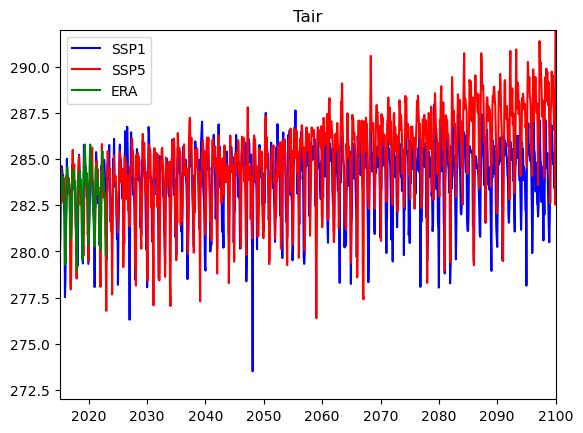

In [10]:
yr_axis1 = np.arange(2015, 2023, (1/12))
yr_axis2 = np.arange(2015, 2101, (1/12))

plt.plot(yr_axis2, sr_tbot_ssp1, 'b-')
plt.plot(yr_axis2, sr_tbot_ssp5, 'r-')
plt.plot(yr_axis1, sr_tbot_era, 'g-')
plt.xlim([2015, 2100])
plt.ylim([272, 292])
plt.legend(['SSP1', 'SSP5', 'ERA'])
plt.title('Tair')
plt.savefig('Tair_future.png')

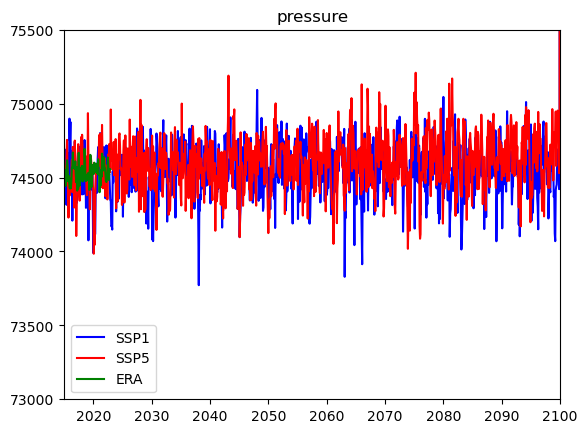

In [11]:
yr_axis1 = np.arange(2015, 2023, (1/12))
yr_axis2 = np.arange(2015, 2101, (1/12))

plt.plot(yr_axis2, sr_pbot_ssp1, 'b-')
plt.plot(yr_axis2, sr_pbot_ssp5, 'r-')
plt.plot(yr_axis1, sr_pbot_era, 'g-')
plt.xlim([2015, 2100])
plt.ylim([73000, 75500])
plt.legend(['SSP1', 'SSP5', 'ERA'])
plt.title('pressure')
plt.savefig('Pressure_future.png')

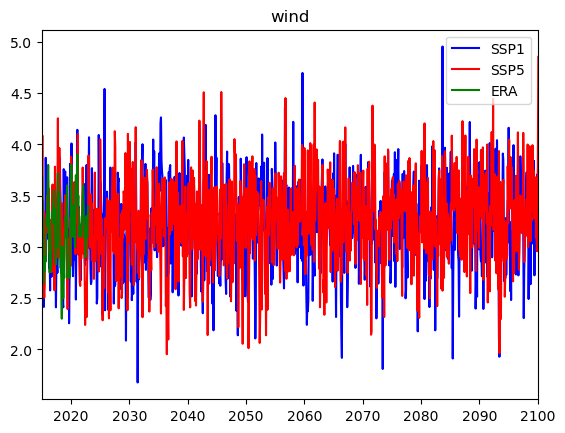

In [12]:
yr_axis1 = np.arange(2015, 2023, (1/12))
yr_axis2 = np.arange(2015, 2101, (1/12))

plt.plot(yr_axis2, sr_wind_ssp1, 'b-')
plt.plot(yr_axis2, sr_wind_ssp5, 'r-')
plt.plot(yr_axis1, sr_wind_era, 'g-')
plt.xlim([2015, 2100])
plt.legend(['SSP1', 'SSP5', 'ERA'])
# plt.ylim([73000, 75500])
plt.title('wind')
plt.savefig('Wind_future.png')

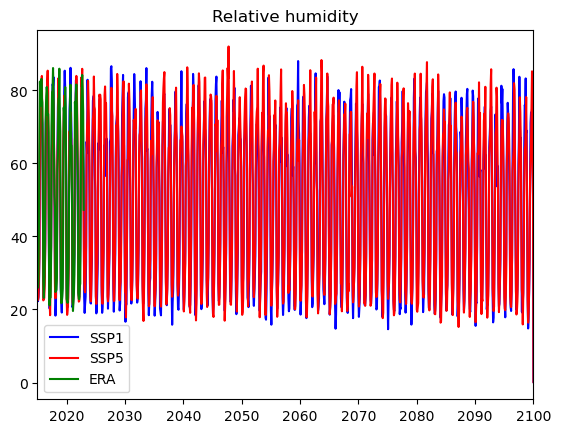

In [13]:
yr_axis1 = np.arange(2015, 2023, (1/12))
yr_axis2 = np.arange(2015, 2101, (1/12))

plt.plot(yr_axis2, sr_rh_ssp1, 'b-')
plt.plot(yr_axis2, sr_rh_ssp5, 'r-')
plt.plot(yr_axis1, sr_rh_era, 'g-')
plt.legend(['SSP1', 'SSP5', 'ERA'])
plt.xlim([2015, 2100])
# plt.ylim([73000, 75500])
plt.title('Relative humidity')
plt.savefig('RH_future.png')

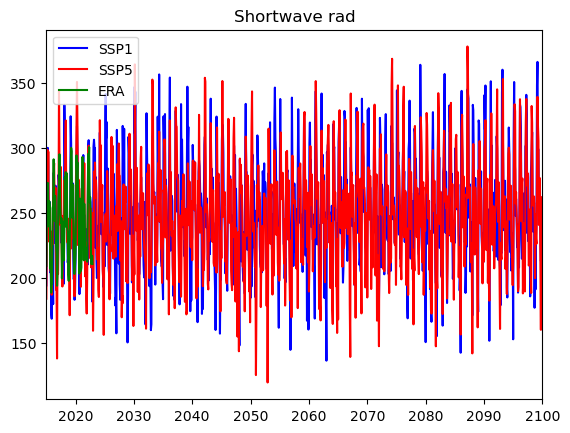

In [14]:
yr_axis1 = np.arange(2015, 2023, (1/12))
yr_axis2 = np.arange(2015, 2101, (1/12))

plt.plot(yr_axis2, sr_sw_ssp1, 'b-')
plt.plot(yr_axis2, sr_sw_ssp5, 'r-')
plt.plot(yr_axis1, sr_sw_era, 'g-')
plt.xlim([2015, 2100])
# plt.ylim([73000, 75500])
plt.legend(['SSP1', 'SSP5', 'ERA'])
plt.title('Shortwave rad')
plt.savefig('SW_future.png')

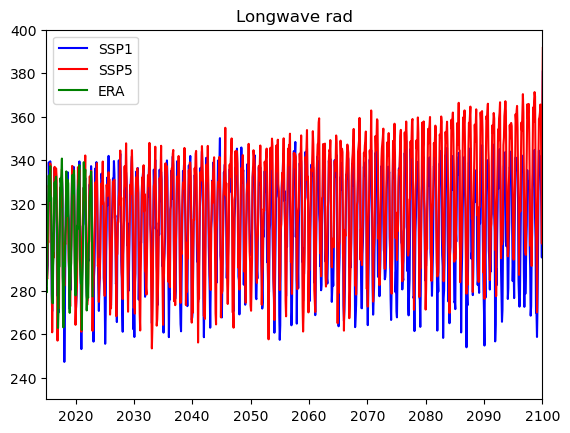

In [15]:
yr_axis1 = np.arange(2015, 2023, (1/12))
yr_axis2 = np.arange(2015, 2101, (1/12))

plt.plot(yr_axis2, sr_lw_ssp1, 'b-')
plt.plot(yr_axis2, sr_lw_ssp5, 'r-')
plt.plot(yr_axis1, sr_lw_era, 'g-')
plt.xlim([2015, 2100])
plt.ylim([230, 400])
plt.legend(['SSP1', 'SSP5', 'ERA'])
plt.title('Longwave rad')
plt.savefig('LW_future.png')

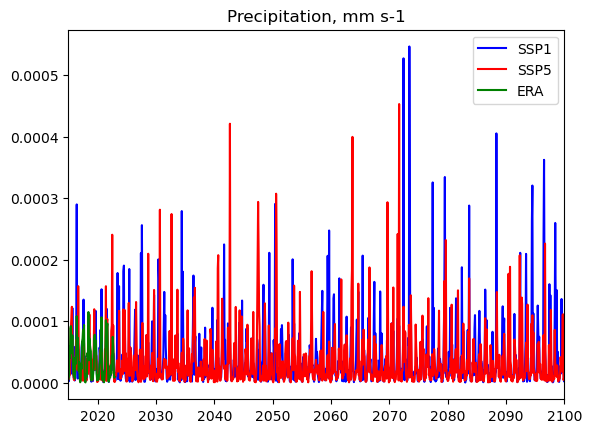

In [16]:
yr_axis1 = np.arange(2015, 2023, (1/12))
yr_axis2 = np.arange(2015, 2101, (1/12))

plt.plot(yr_axis2, sr_rain_ssp1, 'b-')
plt.plot(yr_axis2, sr_rain_ssp5, 'r-')
plt.plot(yr_axis1, sr_rain_era, 'g-')
plt.legend(['SSP1', 'SSP5', 'ERA'])
plt.xlim([2015, 2100])
# plt.ylim([230, 400])
plt.title('Precipitation, mm s-1')
plt.savefig('P_future.png')

### Manipulate met data for test purpose

In [3]:
# Want to perform a sanity check when switching climate forcing from hourly to 3 hourly
# ERA5 hourly data
f_path_local = '/pscratch/sd/s/sshu3/FATES_MRV/sanrafael/CLM1PT_data/'
f_path_new = '/pscratch/sd/s/sshu3/cesm_input_datasets/atm/datm7/sanrafael_era5_3hourly/'
# ssp145 3 hourly data path


In [16]:
# Open and read ERA data
start = time.time()

f_suf = '.nc'

yrbeg = 1979
yrend = 2023

for i in np.arange(yrbeg,yrend):
    for j in np.arange(1,13):
        dom = np.array((31, 28, 31, 30, 31, 30, 31, 31, 30, 31, 30, 31))
        nlen = 24 * dom[j-1]
        
        # TBOT
        if(j < 10):
            fp = f_path_local+str(i)+'-0'+str(j)+f_suf
        else:
            fp = f_path_local+str(i)+'-'+str(j)+f_suf
        dtc = nc4.Dataset(fp)
        dtbot = dtc['TBOT'][:]
        drh = dtc['RH'][:]
        dprec = dtc['PRECTmms'][:]
        dfsds = dtc['FSDS'][:]
        dflds = dtc['FLDS'][:]
        dpbot = dtc['PSRF'][:]
        dwind = dtc['WIND'][:]
        
        dtc.close()       

        # Average per 3-hour
        dtbot_new = np.mean(dtbot[:,0,0].reshape(-1, 3), axis=1)
        drh_new = np.mean(drh[:,0,0].reshape(-1, 3), axis=1)
        dprec_new = np.mean(dprec[:,0,0].reshape(-1, 3), axis=1)
        dfsds_new = np.mean(dfsds[:,0,0].reshape(-1, 3), axis=1)
        dflds_new = np.mean(dflds[:,0,0].reshape(-1, 3), axis=1)
        dpbot_new = np.mean(dpbot[:,0,0].reshape(-1, 3), axis=1)
        dwind_new = np.mean(dwind[:,0,0].reshape(-1, 3), axis=1)

        if(i>=2018):
            # Write values into new files
            if(j < 10):
                fp_new = f_path_new+str(i)+'-0'+str(j)+f_suf
            else:
                fp_new = f_path_new+str(i)+'-'+str(j)+f_suf
        else:
            if(j < 10):
                fp_new = f_path_new+str(i+44)+'-0'+str(j)+f_suf
            else:
                fp_new = f_path_new+str(i+44)+'-'+str(j)+f_suf            

        dtc = nc4.Dataset(fp_new, 'r+')
        dtc['TBOT'][:] = dtbot_new
        dtc['PSRF'][:] = dpbot_new
        dtc['PRECTmms'][:] = dprec_new
        dtc['WIND'][:] = dwind_new
        dtc['FSDS'][:] = dfsds_new
        dtc['FLDS'][:] = dflds_new
        dtc['RH'][:] = drh_new
        dtc.close()
        
        #     fp = f_era_prec_pre+str(i)+'-0'+str(j)+suf
        # else:
        #     fp = f_era_prec_pre+str(i)+'-'+str(j)+suf    
        # dtc = nc4.Dataset(fp)
        # dprec = dtc['mcpr']
        # temp_array_1 = dprec[:,latid_sr_era,lonid_sr_era]
        # dtc.close()
        # if(j < 10):
        #     fp = f_era_prel_pre+str(i)+'-0'+str(j)+suf
        # else:
        #     fp = f_era_prel_pre+str(i)+'-'+str(j)+suf    
        # dtc = nc4.Dataset(fp)
        # dprel = dtc['mlspr']
        # temp_array_2 = dprel[:,latid_sr_era,lonid_sr_era]
        # dtc.close()               
        # sr_prec_era = copy.deepcopy(temp_array_1+temp_array_2)
        
        # # Wind, 10 m wind speed, m s-1
        # if(j < 10):
        #     fp = f_era_wind_pre+str(i)+'-0'+str(j)+suf
        # else:
        #     fp = f_era_wind_pre+str(i)+'-'+str(j)+suf    
        # dtc = nc4.Dataset(fp)
        # dwind_u = dtc['u10']
        # dwind_v = dtc['v10']
        # temp_array_1u = dwind_u[:,latid_sr_era,lonid_sr_era]
        # temp_array_1v = dwind_v[:,latid_sr_era,lonid_sr_era]
        # dtc.close()
        # sr_wind_era = copy.deepcopy(np.sqrt(temp_array_1u*temp_array_1u+temp_array_1v*temp_array_1v))
        
        # # Radiation, W m-2
        # if(j < 10):
        #     fp = f_era_rad_pre+str(i)+'-0'+str(j)+suf
        # else:
        #     fp = f_era_rad_pre+str(i)+'-'+str(j)+suf    
        # dtc = nc4.Dataset(fp)
        # drad = dtc['msdwswrf']
        # temp_array_1 = drad[:,latid_sr_era,lonid_sr_era]
        # dtc.close()
        # sr_rad_era = copy.deepcopy(temp_array_1)
        
        # # Longwave radiation, W m-2
        # if(j < 10):
        #     fp = f_era_lwdn_pre+str(i)+'-0'+str(j)+suf
        # else:
        #     fp = f_era_lwdn_pre+str(i)+'-'+str(j)+suf    
        # dtc = nc4.Dataset(fp)
        # drad = dtc['msdwlwrf']
        # temp_array_1 = drad[:,latid_sr_era,lonid_sr_era]
        # dtc.close()
        # sr_lrad_era = copy.deepcopy(temp_array_1)
        
        # # Dew point T, K
        # if(j < 10):
        #     fp = f_era_dewt_pre+str(i)+'-0'+str(j)+suf
        # else:
        #     fp = f_era_dewt_pre+str(i)+'-'+str(j)+suf    
        # dtc = nc4.Dataset(fp)
        # d2m = dtc['d2m']
        # temp_array_1 = d2m[:,latid_sr_era,lonid_sr_era]
        # dtc.close()
        # sr_tdew_era = copy.deepcopy(temp_array_1)
        
        # # Surface pressure, Pa
        # if(j < 10):
        #     fp = f_era_pbot_pre+str(i)+'-0'+str(j)+suf
        # else:
        #     fp = f_era_pbot_pre+str(i)+'-'+str(j)+suf    
        # dtc = nc4.Dataset(fp)
        # dsp = dtc['sp']
        # temp_array_1 = dsp[:,latid_sr_era,lonid_sr_era]
        # dtc.close()
        # sr_pbot_era = copy.deepcopy(temp_array_1)
        
        # # # Transfer dew point temperature to specific humidity
        # # dew = sr_tdew_era - 273.16
        # # ea = a1 +dew*(a2+dew*(a3+dew*(a4+dew*(a5+dew*(a6+dew*a7)))))
        # # ea = ea * 100.0 # Conversion millibar --> Pascal
        # # # 0.62198 - humidity ratio
        # # sr_qa_era = 0.62198*ea/(sr_pbot_era - 0.377*ea)
        
        # # Transfer dew point temperature to relative humidity
        # dew = sr_tdew_era - 273.16
        # tair = sr_tbot_era - 273.16
        # ea = a1 +dew*(a2+dew*(a3+dew*(a4+dew*(a5+dew*(a6+dew*a7)))))
        # es = a1 +tair*(a2+tair*(a3+tair*(a4+tair*(a5+tair*(a6+tair*a7)))))
        # sr_rh_era = ea/(es+1e-10)
      
        # # Write into corresponding file
        # if(j < 10):
        #     fp = fout_pre+str(i)+'-0'+str(j)+fout_suf
        # else:
        #     fp = fout_pre+str(i)+'-'+str(j)+fout_suf
        # dtc = nc4.Dataset(fp, 'r+')
        # dtc['TBOT'][:] = sr_tbot_era
        # dtc['PSRF'][:] = sr_pbot_era
        # dtc['PRECTmms'][:] = sr_prec_era
        # dtc['WIND'][:] = sr_wind_era
        # dtc['FSDS'][:] = sr_rad_era
        # dtc['FLDS'][:] = sr_lrad_era
        # dtc['RH'][:] = sr_rh_era
        # dtc.close()

end = time.time()
print('Time elapsed: ', end - start)
        

Time elapsed:  7.099557399749756


In [8]:
np.shape(dtbot_new)

(248,)

In [15]:
2023 - 1979

44